In [ ]:
'''
Clustering: PCA| K-Means - DBSCAN - Hierarchical |
'''

In [ ]:
'''
Цель :
Группировать страны по числовым признакам.
Это постановка проблемы обучения без учителя.
Атрибуты набора данных
country: Название страны
child_mort : Смертность детей в возрасте до 5 лет на 1000 живорождений.
exports: Экспорт товаров и услуг на душу населения. Выражено в % от ВВП на душу населения.
health: Общие расходы на здравоохранение на душу населения. Выражено в % от ВВП на душу населения.
imports: Импорт товаров и услуг на душу населения. Выражено в % от ВВП на душу населения.
Income: Чистый доход на человека
Inflation: измерение ежегодных темпов роста общего ВВП.
life_expec : Среднее количество лет, которое прожил бы новорожденный ребенок, если бы нынешнюю структуру смертности удалось сохранить...
total_fer : Число детей, которые родились бы у каждой женщины, если текущий возрастной коэффициент рождаемости останется на уровне...
gdpp: ВВП на душу населения. Рассчитывается как общий ВВП, разделенный на общую численность населения.

Содержание блокнота:
Информация о наборе данных
Исследовательский анализ данных (EDA)
Feature Engineering
Моделирование

Заключение
Что мы узнаем:
Методы визуализации данных.
Feature Engineering и PCA.
Производительность модели кластеризации K-Means против кластеризации DBSCAN и иерархической кластеризации.
'''

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

import plotly.express as px
!pip install -U kaleido
import kaleido

In [2]:
data = pd.read_csv('Country-data.csv')
data.head()

country  child_mort  exports  health  imports  income  \
0          Afghanistan       90.20    10.00    7.58    44.90    1610   
1              Albania       16.60    28.00    6.55    48.60    9930   
2              Algeria       27.30    38.40    4.17    31.40   12900   
3               Angola      119.00    62.30    2.85    42.90    5900   
4  Antigua and Barbuda       10.30    45.50    6.03    58.90   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44       56.20       5.82    553  
1       4.49       76.30       1.65   4090  
2      16.10       76.50       2.89   4460  
3      22.40       60.10       6.16   3530  
4       1.44       76.80       2.13  12200

In [3]:
data.shape

(167, 10)

In [4]:
data.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


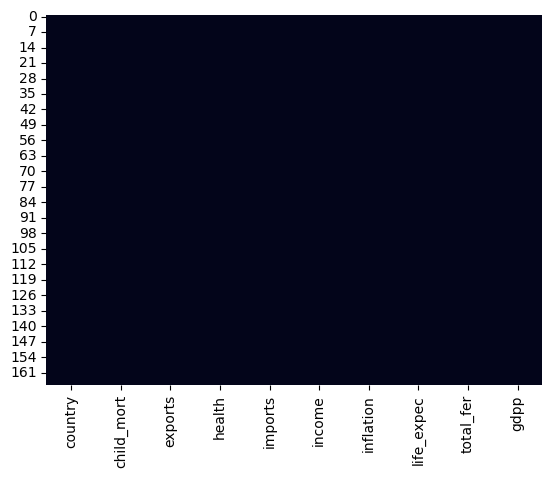

In [6]:
sns.heatmap(data.isnull(), cbar = False);

In [ ]:
'''
В данных нет нулевых значений!
'''

In [7]:
data.describe()

child_mort  exports  health  imports    income  inflation  life_expec  \
count      167.00   167.00  167.00   167.00    167.00     167.00      167.00   
mean        38.27    41.11    6.82    46.89  17144.69       7.78       70.56   
std         40.33    27.41    2.75    24.21  19278.07      10.57        8.89   
min          2.60     0.11    1.81     0.07    609.00      -4.21       32.10   
25%          8.25    23.80    4.92    30.20   3355.00       1.81       65.30   
50%         19.30    35.00    6.32    43.30   9960.00       5.39       73.10   
75%         62.10    51.35    8.60    58.75  22800.00      10.75       76.80   
max        208.00   200.00   17.90   174.00 125000.00     104.00       82.80   

       total_fer      gdpp  
count     167.00    167.00  
mean        2.95  12964.16  
std         1.51  18328.70  
min         1.15    231.00  
25%         1.79   1330.00  
50%         2.41   4660.00  
75%         3.88  14050.00  
max         7.49 105000.00

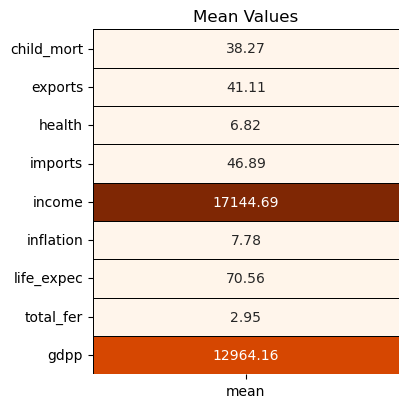

In [8]:
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5))

colors = ['#FF781F','#2D2926']
plt.subplot(1,1,1)
sns.heatmap(data.describe().T[['mean']],cmap = 'Oranges',annot = True,fmt = '.2f',linecolor = 'black',linewidths = 0.4,cbar = False);
plt.title('Mean Values');

fig.tight_layout(pad = 4)

In [ ]:
'''
Exploratory Data Analysis
'''

In [9]:
col = list(data.columns)
col.remove('country')
categorical_features = ['country']
numerical_features = [*col]
print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : country
Numerical Features : child_mort exports health imports income inflation life_expec total_fer gdpp


In [ ]:
'''
Для этого набора данных, поскольку количество объектов меньше, мы проверяем набор данных вручную.
Очевидно, что, за исключением страны, все объекты являются числовыми объектами, а их тип данных элемента может быть либо плавающим, 
либо целочисленным.
Мы используем типичный подход к разделению объектов, т.е. на основе типов данных элементов соответствующего объекта.
Например: тип данных = целое число, признак = числовая признак; тип данных = строка, признак = категориальная признак
'''

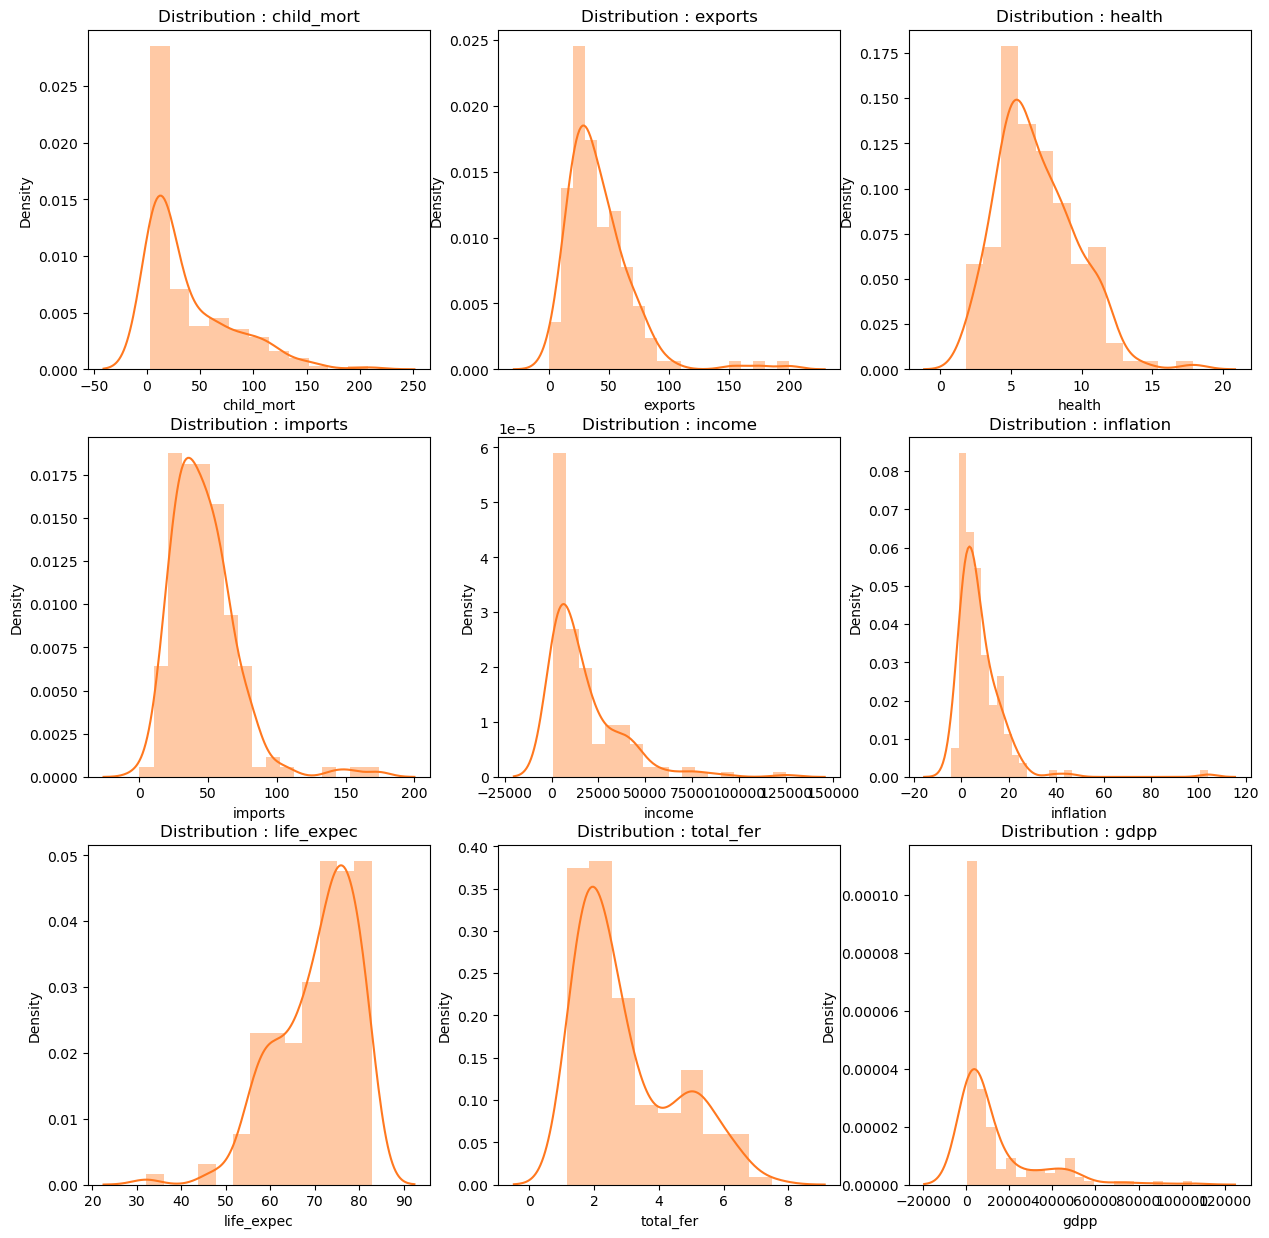

In [10]:
# Распределение признаков:

fig, ax = plt.subplots(nrows = 3,ncols = 3,figsize = (15,15))
for i in range(len(numerical_features)):
    plt.subplot(3,3,i+1)
    sns.distplot(data[numerical_features[i]],color = colors[0])
    title = 'Distribution : ' + numerical_features[i]
    plt.title(title)
plt.show()

In [11]:
len(data['country'].unique()) == len(data)

True

In [ ]:
'''
life_expec отображает левое или отрицательное распределение данных.
Health отображает нормально распространяемые данные.
Все остальные функции показывают правильное или положительно искаженное распределение данных.
Распределение данных по стране не выводится, поскольку оно содержит текстовые данные и имеет такое же количество уникальных значений, 
что и длина кадра данных.
Особенности экономически отсталых стран:
Доход на душу населения в стране очень низкий.
Высокая численность населения, что приводит к недоступности ресурсов.
Безработица из-за меньшего количества ресурсов.
Низкое благосостояние страны, что приводит к низкому капиталу.
Несправедливое распределение богатства и доходов.
Отсутствие надлежащих образовательных условий и, следовательно, преобладает неграмотность.
Низкий уровень жизни.
Никакого технического прогресса.
Плохое медицинское обслуживание в сочетании с высоким уровнем рождаемости и смертности.
Фонду HELP необходимо ориентироваться на страны, обладающие вышеуказанными характеристиками. 
Теперь мы визуализируем данные и найдем страны, которые лежат на крайних точках и в центре каждого объекта, чтобы указать страны, 
которым требуется помощь!
'''

In [ ]:
'''
Country vs Numerical Features.
child_mort : В экономически отсталых странах высокая детская смертность
'''

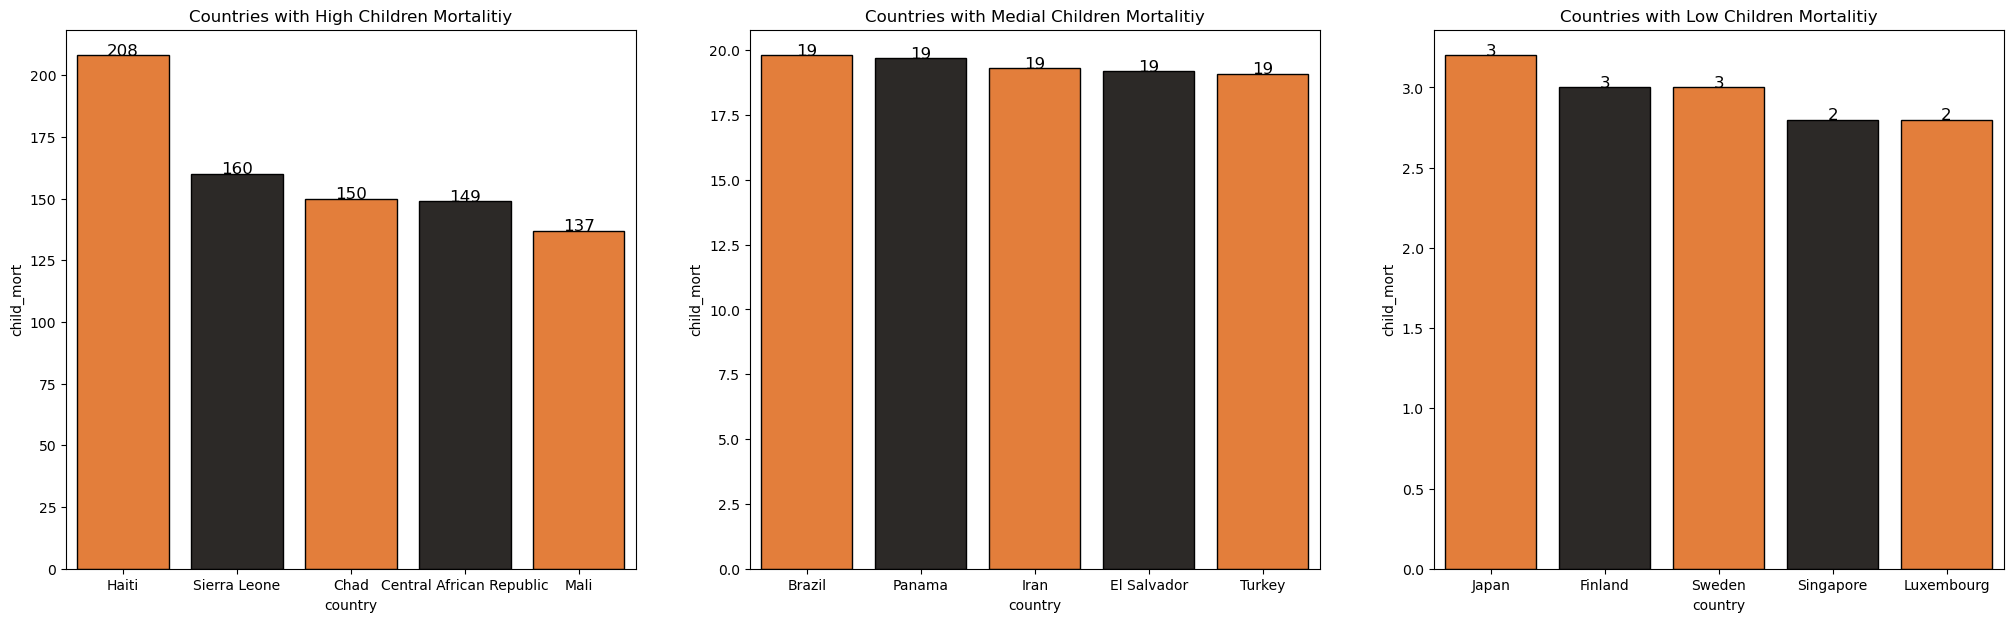

In [12]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,7))
plt.subplot(1,3,1)
ax = sns.barplot(x = 'country',y = 'child_mort', data = data.sort_values(ascending = False,by = 'child_mort').iloc[:5],palette = colors,edgecolor = 'black');
plt.title('Countries with High Children Mortalitiy')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,3,2)
ax = sns.barplot(x = 'country',y = 'child_mort', data = data.sort_values(ascending = False,by = 'child_mort').iloc[81:86],palette = colors,edgecolor = 'black');
plt.title('Countries with Medial Children Mortalitiy')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,3,3)
ax = sns.barplot(x = 'country',y = 'child_mort', data = data.sort_values(ascending = False,by = 'child_mort').iloc[161:166],palette = colors,edgecolor = 'black');
plt.title('Countries with Low Children Mortalitiy')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)
plt.show()

In [ ]:
'''
На Гаити самый высокий уровень детской смертности. 
Африканские страны занимают значительные позиции в этой статистике.
На другом полюсе child_mort прочное присутствие занимают страны Азии и Европы.

Экспорт: Это очень важный фактор для построения экономики страны. 
Чем выше экспорт страны, тем сильнее ее экономика и больше богатства, создаваемого нацией.
'''

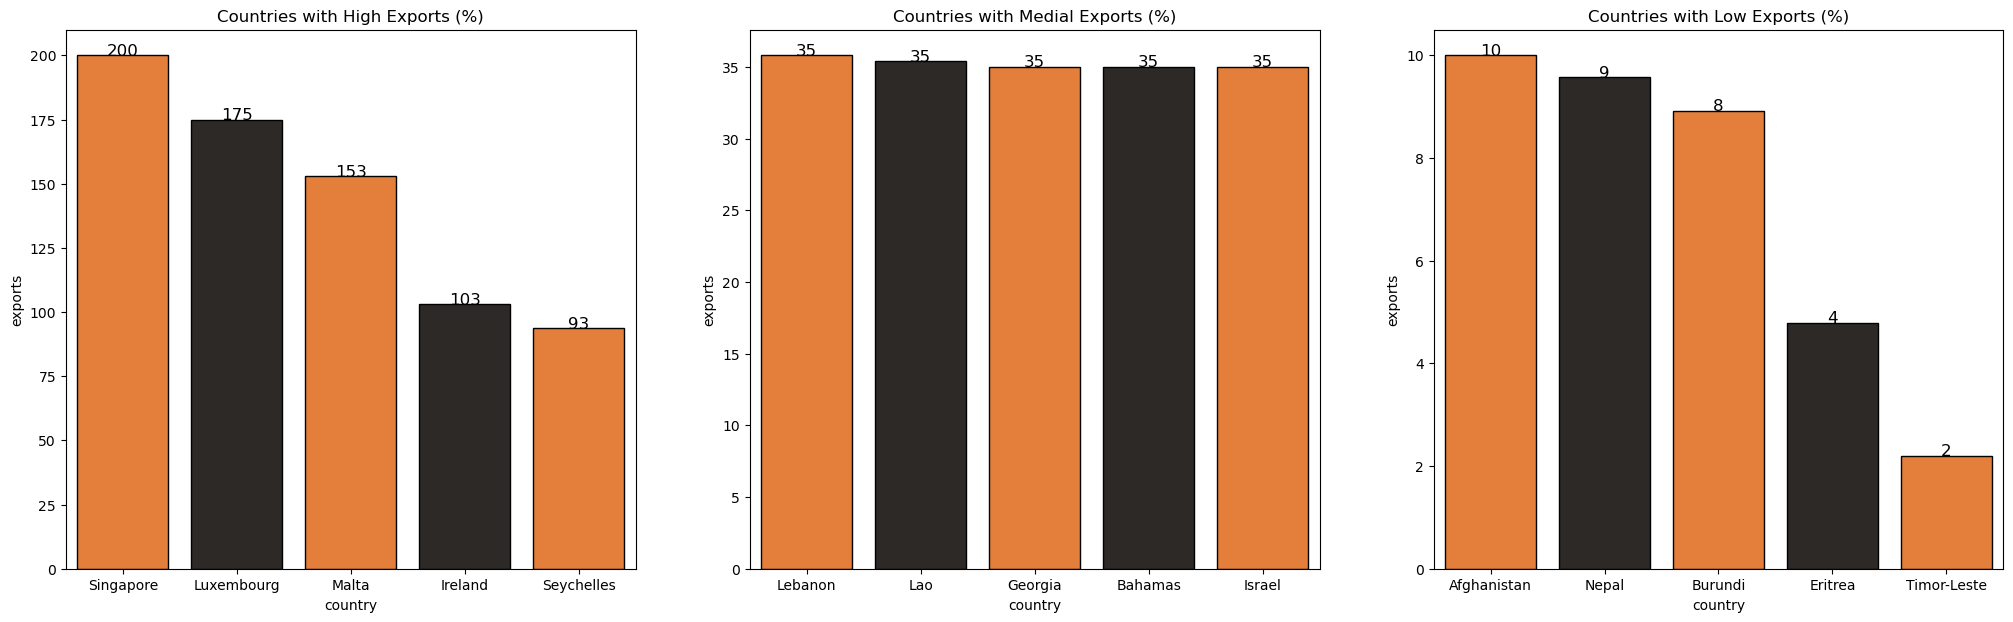

In [13]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,7))
plt.subplot(1,3,1)
ax = sns.barplot(x = 'country',y = 'exports', data = data.sort_values(ascending = False,by = 'exports').iloc[:5],palette = colors,edgecolor = 'black');
plt.title('Countries with High Exports (%)')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,3,2)
ax = sns.barplot(x = 'country',y = 'exports', data = data.sort_values(ascending = False,by = 'exports').iloc[81:86],palette = colors,edgecolor = 'black');
plt.title('Countries with Medial Exports (%)')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,3,3)
ax = sns.barplot(x = 'country',y = 'exports', data = data.sort_values(ascending = False,by = 'exports').iloc[161:166],palette = colors,edgecolor = 'black');
plt.title('Countries with Low Exports (%)')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)
plt.show()


In [ ]:
'''
Экспорт страны обычно представляет собой товары и услуги, созданные внутри страны, но проданные другим странам. 
Экспортируемые товары и услуги зависят от таких факторов, как географическое положение, природные ресурсы, численность населения 
и их предпочтения в отношении конкретных навыков и т. д.
Несмотря на то, что по численности населения Сингапур не входит в число 100 крупнейших стран, у него самый высокий объем экспорта. 
Люксембург и Мальта, вероятно, пошли по тому же пути.
Афганистан и Непал входят в нижнюю часть экспорта. Географическое положение этих стран имеет большое влияние. 
Страны с более низким уровнем экспорта также имеют небольшую географическую территорию.

Health: Граждане развитых стран имеют более высокий доход, и поэтому у них нет проблем тратить больше средств на здоровый образ жизни.
'''

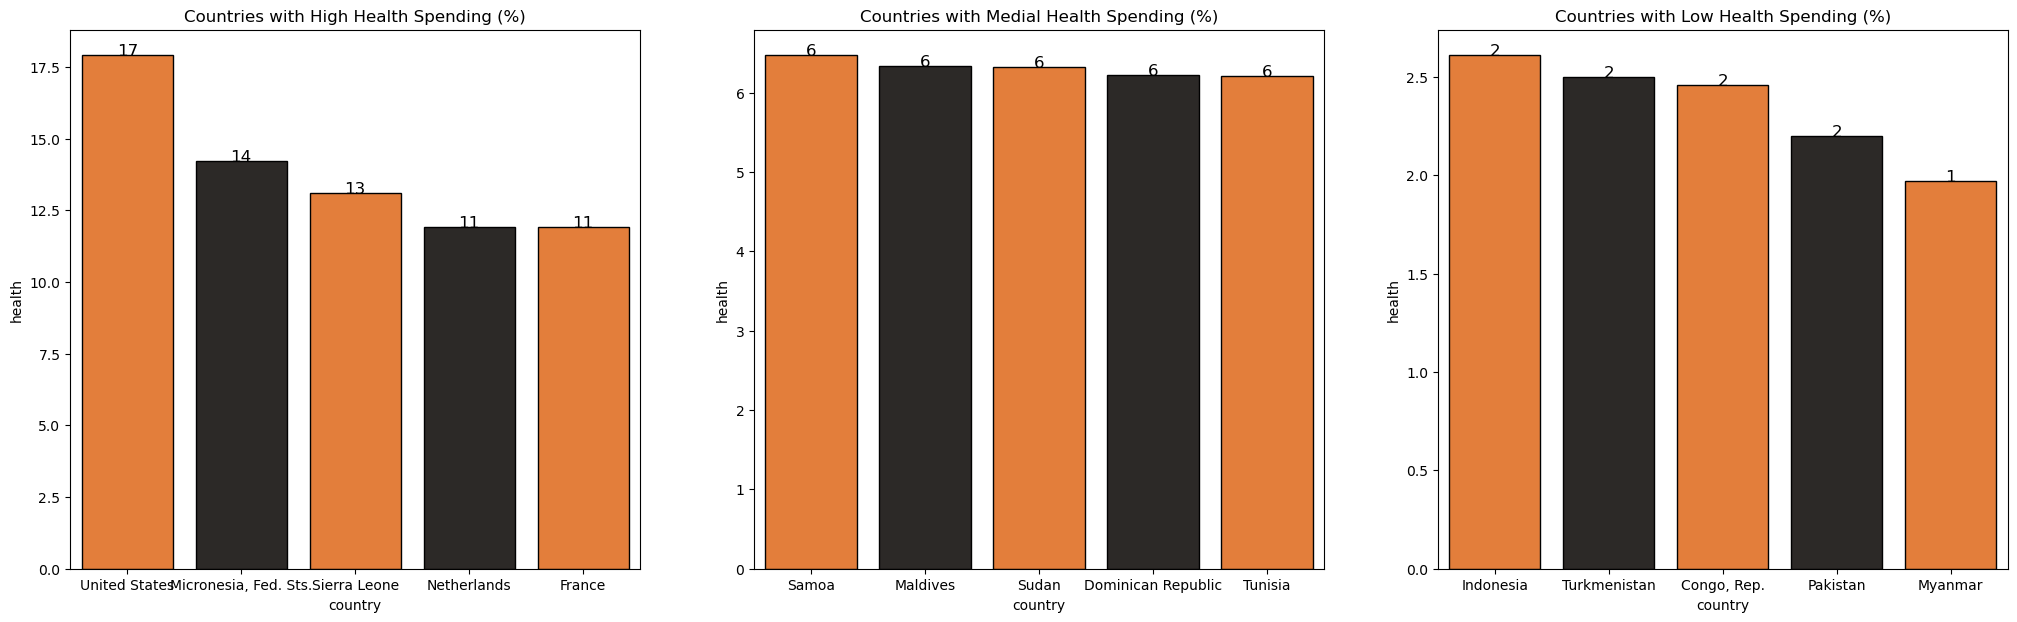

In [14]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,7))
plt.subplot(1,3,1)
ax = sns.barplot(x = 'country',y = 'health', data = data.sort_values(ascending = False,by = 'health').iloc[:5],palette = colors,edgecolor = 'black');
plt.title('Countries with High Health Spending (%)')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,3,2)
ax = sns.barplot(x = 'country',y = 'health', data = data.sort_values(ascending = False,by = 'health').iloc[81:86],palette = colors,edgecolor = 'black');
plt.title('Countries with Medial Health Spending (%)')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,3,3)
ax = sns.barplot(x = 'country',y = 'health', data = data.sort_values(ascending = False,by = 'health').iloc[161:166],palette = colors,edgecolor = 'black');
plt.title('Countries with Low Health Spending (%)')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)
plt.show()

In [ ]:
'''
США занимают первое место по расходам на здравоохранение с 17% индивидуального вклада в ВВП.
Кажется, 6% — это средние значения расходов граждан на свое здоровье.
Азиатские страны доминируют на нижнем уровне здравоохранения с показателем менее 3%. Они самые невежественные граждане, 
когда дело касается здоровья.

Imports: это еще один атрибут, который определяет зависимость стран от других стран в отношении товаров и услуг.
'''

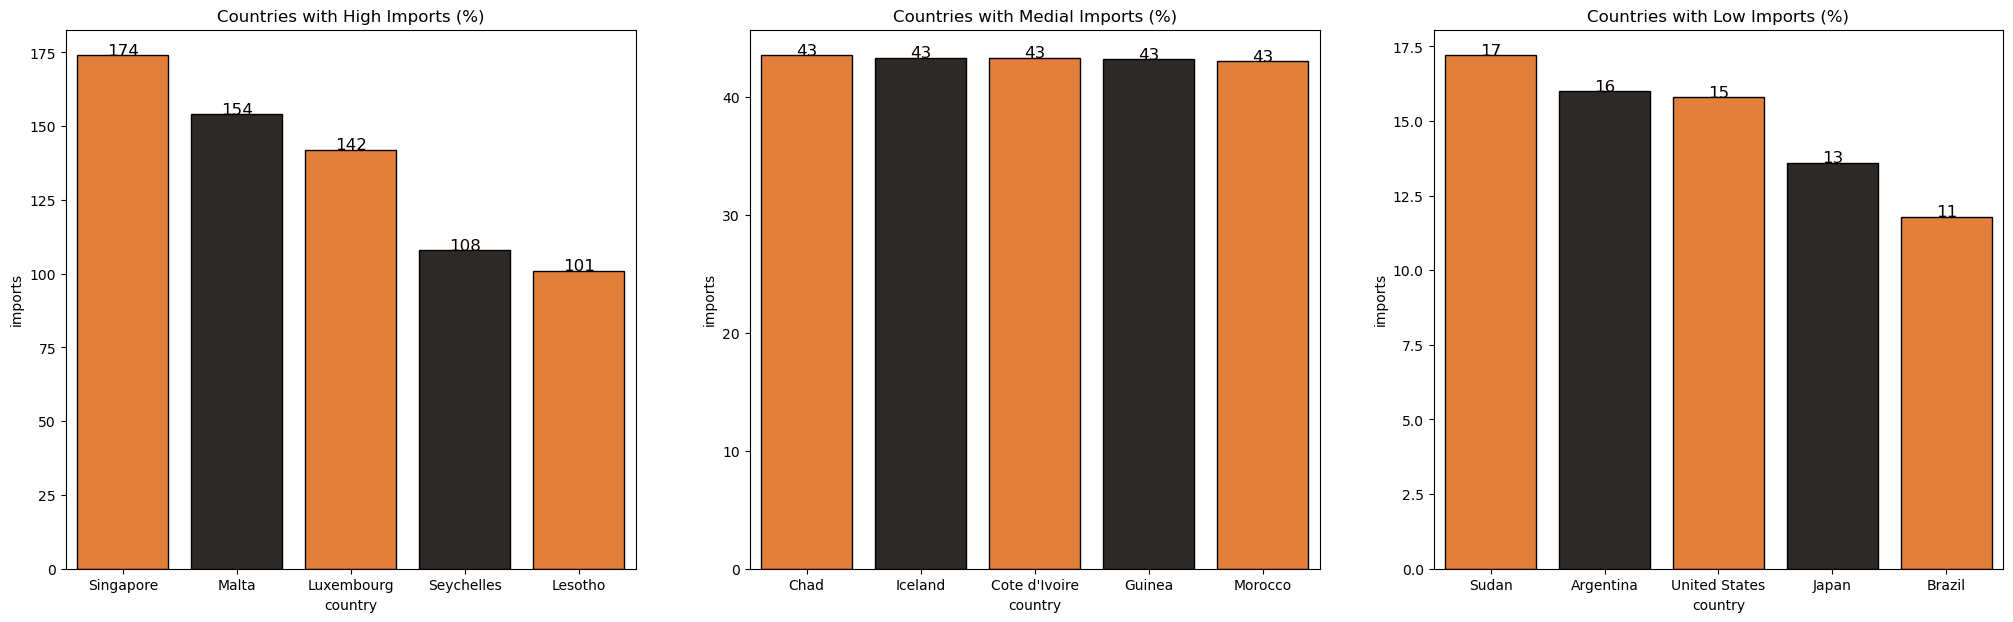

In [15]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,7))
plt.subplot(1,3,1)
ax = sns.barplot(x = 'country',y = 'imports', data = data.sort_values(ascending = False,by = 'imports').iloc[:5],palette = colors,edgecolor = 'black');
plt.title('Countries with High Imports (%)')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,3,2)
ax = sns.barplot(x = 'country',y = 'imports', data = data.sort_values(ascending = False,by = 'imports').iloc[81:86],palette = colors,edgecolor = 'black');
plt.title('Countries with Medial Imports (%)')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,3,3)
ax = sns.barplot(x = 'country',y = 'imports', data = data.sort_values(ascending = False,by = 'imports').iloc[161:166],palette = colors,edgecolor = 'black');
plt.title('Countries with Low Imports (%)')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)
plt.show()

In [ ]:
'''
Статистика импорта нации описывает ее уверенность в своих силах в решении своих проблем, независимо от того, 
ограничена ли она в использовании одного из важнейших ресурсов.
Сингапур, Мальта, Люксембург и Сейшельские острова входят в пятерку крупнейших стран экспорта, а также импорта. 
Это всего лишь показатель, подчеркивающий стратегию страны, которая, вероятно, 
извлекает выгоду из своих ресурсов и создает надежный экспорт, которому противостоит тяжелый импорт чего-то еще. 
Это просто уравновешивает баланс.
В Бразилии самый низкий импорт из всех стран — 11%. 
Судан — единственная африканская страна, присутствующая в этом нижнем списке с 17%.

Income: Доход на человека является ключевым индикатором экономического состояния страны. 
Чем выше доходы граждан, тем больше у них возможностей справляться с неопределенными ситуациями.
'''

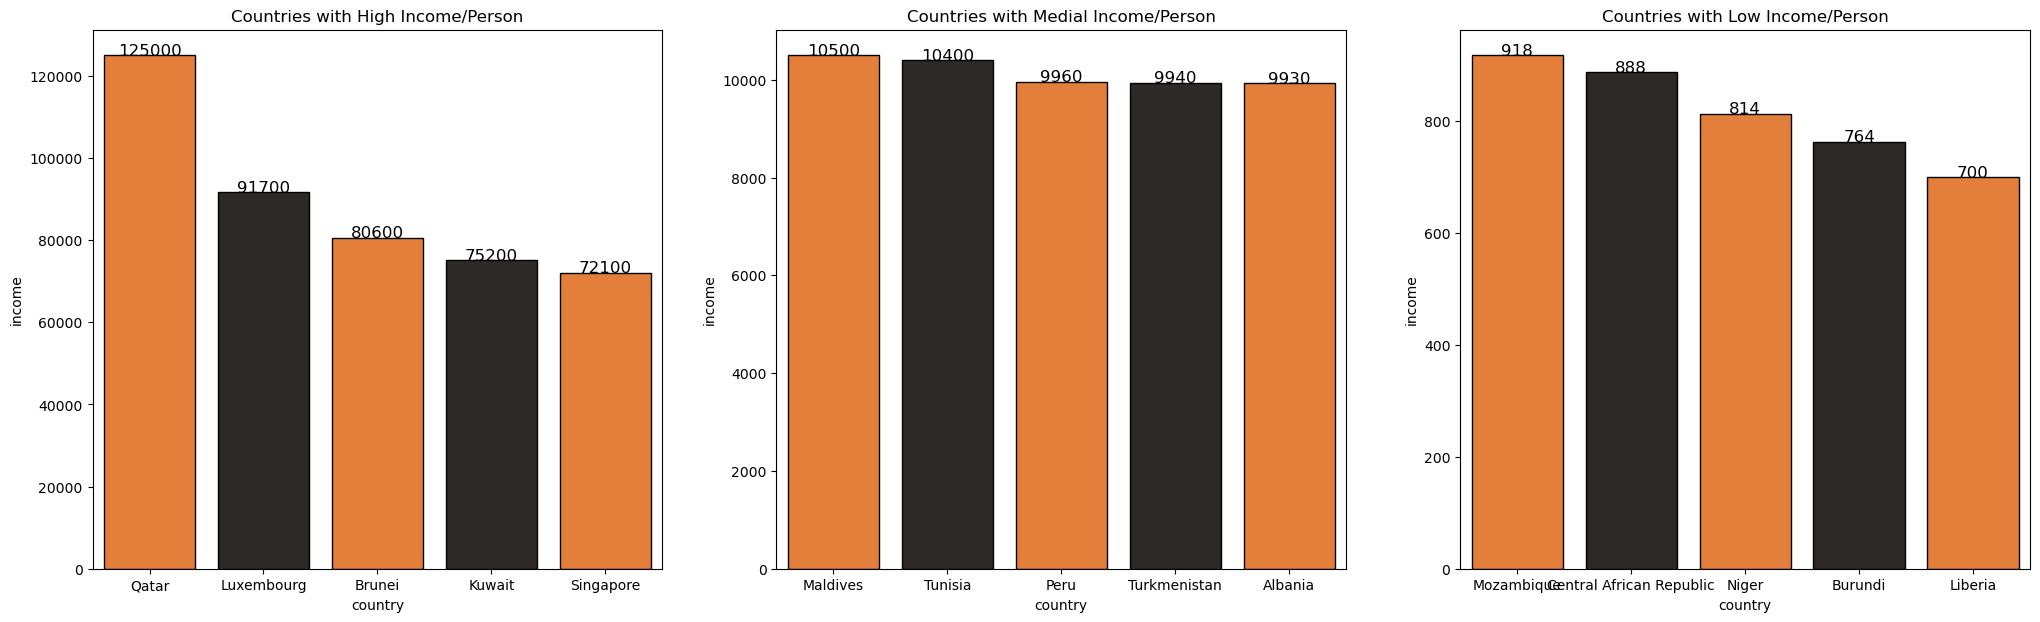

In [16]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,7))
plt.subplot(1,3,1)
ax = sns.barplot(x = 'country',y = 'income', data = data.sort_values(ascending = False,by = 'income').iloc[:5],palette = colors,edgecolor = 'black');
plt.title('Countries with High Income/Person')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,3,2)
ax = sns.barplot(x = 'country',y = 'income', data = data.sort_values(ascending = False,by = 'income').iloc[81:86],palette = colors,edgecolor = 'black');
plt.title('Countries with Medial Income/Person')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,3,3)
ax = sns.barplot(x = 'country',y = 'income', data = data.sort_values(ascending = False,by = 'income').iloc[161:166],palette = colors,edgecolor = 'black');
plt.title('Countries with Low Income/Person')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)
plt.show()

In [ ]:
'''
Граждане Катара имеют самый высокий доход из всех стран с разницей в 30 тысяч больше, чем у стран, занявших второе место. 
Сингапур и Люксембург снова вошли в пятерку лучших по другому показателю.
В нижнем сегменте доходов преобладают африканские страны. 
На это влияет ущерб, нанесенный колонизацией, от которой страны еще не оправились.
Разница в доходах стран верхнего, среднего и нижнего уровня весьма значительна, что повлияет на все остальные характеристики.

Inflation: она определяет состояние экономики, силу валюты, а также спрос на товары и услуги.
'''

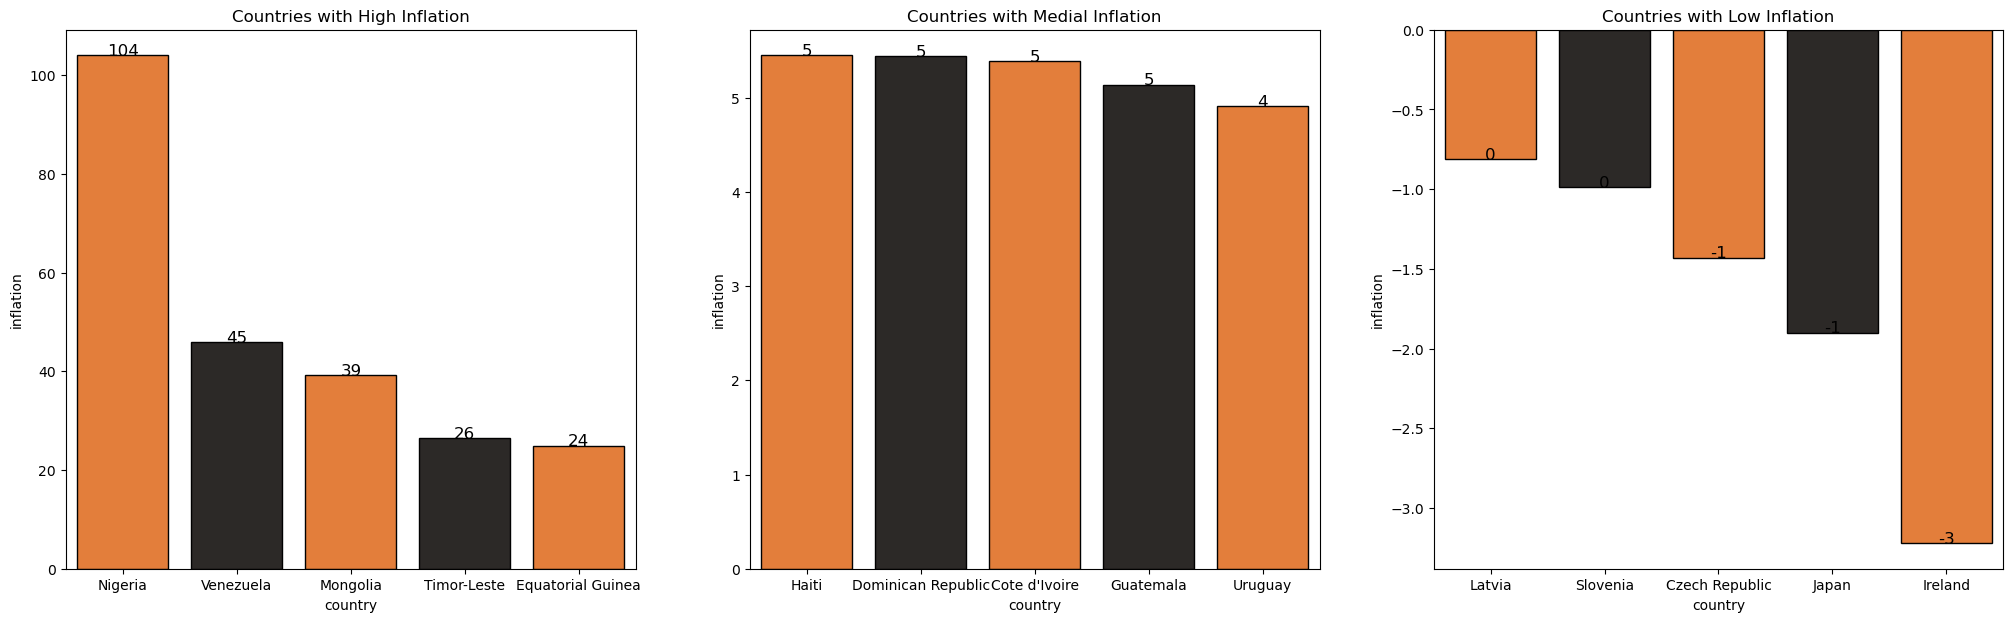

In [17]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,7))
plt.subplot(1,3,1)
ax = sns.barplot(x = 'country',y = 'inflation', data = data.sort_values(ascending = False,by = 'inflation').iloc[:5],palette = colors,edgecolor = 'black');
plt.title('Countries with High Inflation')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,3,2)
ax = sns.barplot(x = 'country',y = 'inflation', data = data.sort_values(ascending = False,by = 'inflation').iloc[81:86],palette = colors,edgecolor = 'black');
plt.title('Countries with Medial Inflation')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,3,3)
ax = sns.barplot(x = 'country',y = 'inflation', data = data.sort_values(ascending = False,by = 'inflation').iloc[161:166],palette = colors,edgecolor = 'black');
plt.title('Countries with Low Inflation')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)
plt.show()

In [ ]:
'''
Рост инфляции снижает покупательную способность граждан. Страны, находящиеся на верхнем уровне инфляции, 
имеют разрушительную экономическую ситуацию. Столь высокая инфляция представляет собой риск для существования нации.
Точно так же нижний предел инфляции имеет отрицательные значения, т.е. известный как дефляция. 
Это сигнализирует о том, что экономика находится в нисходящей спирали, ведущей к рецессии или даже депрессии.

Life_expec: более высокая продолжительность жизни показывает, что граждане обладают физическими и умственными качествами здоровья.
'''

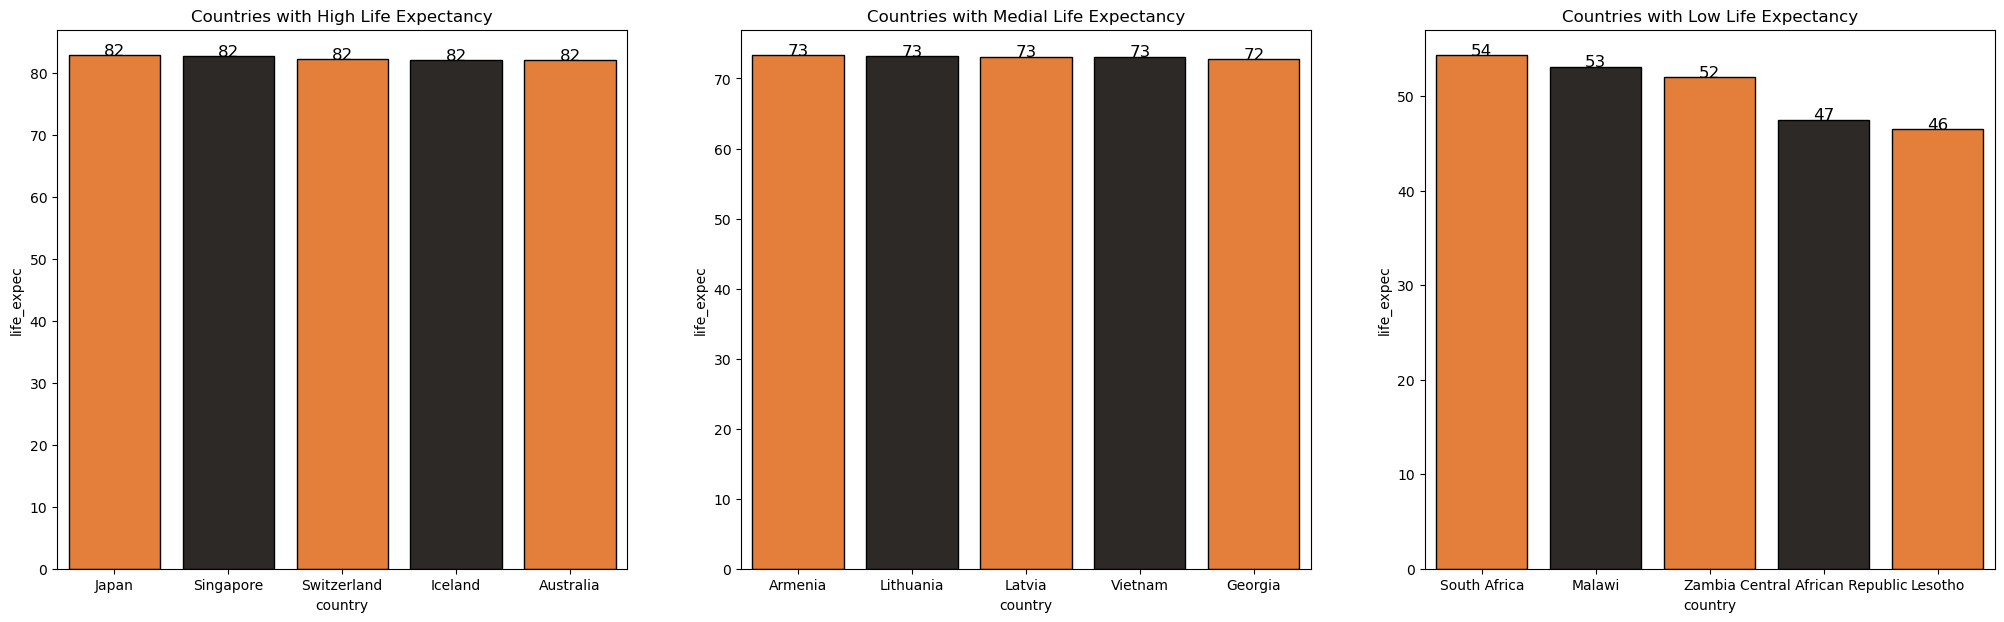

In [18]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,7))
plt.subplot(1,3,1)
ax = sns.barplot(x = 'country',y = 'life_expec', data = data.sort_values(ascending = False,by = 'life_expec').iloc[:5],palette = colors,edgecolor = 'black');
plt.title('Countries with High Life Expectancy')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,3,2)
ax = sns.barplot(x = 'country',y = 'life_expec', data = data.sort_values(ascending = False,by = 'life_expec').iloc[81:86],palette = colors,edgecolor = 'black');
plt.title('Countries with Medial Life Expectancy')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,3,3)
ax = sns.barplot(x = 'country',y = 'life_expec', data = data.sort_values(ascending = False,by = 'life_expec').iloc[161:166],palette = colors,edgecolor = 'black');
plt.title('Countries with Low Life Expectancy')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)
plt.show()

In [ ]:
'''
Life_expec во многом зависит от психического состояния, а также образа жизни граждан. 
Сингапур снова присутствует в топ-5 по характеристикам.
Ни одна из стран с высоким показателем life_expec не входит в топ-5 стран по здравоохранению, 
что связано с расходами граждан на здравоохранение.
Африканские страны снова оказались в нижней части рейтинга по другой причине.

Total_fer: В экономически отсталых странах высокий уровень рождаемости.
'''

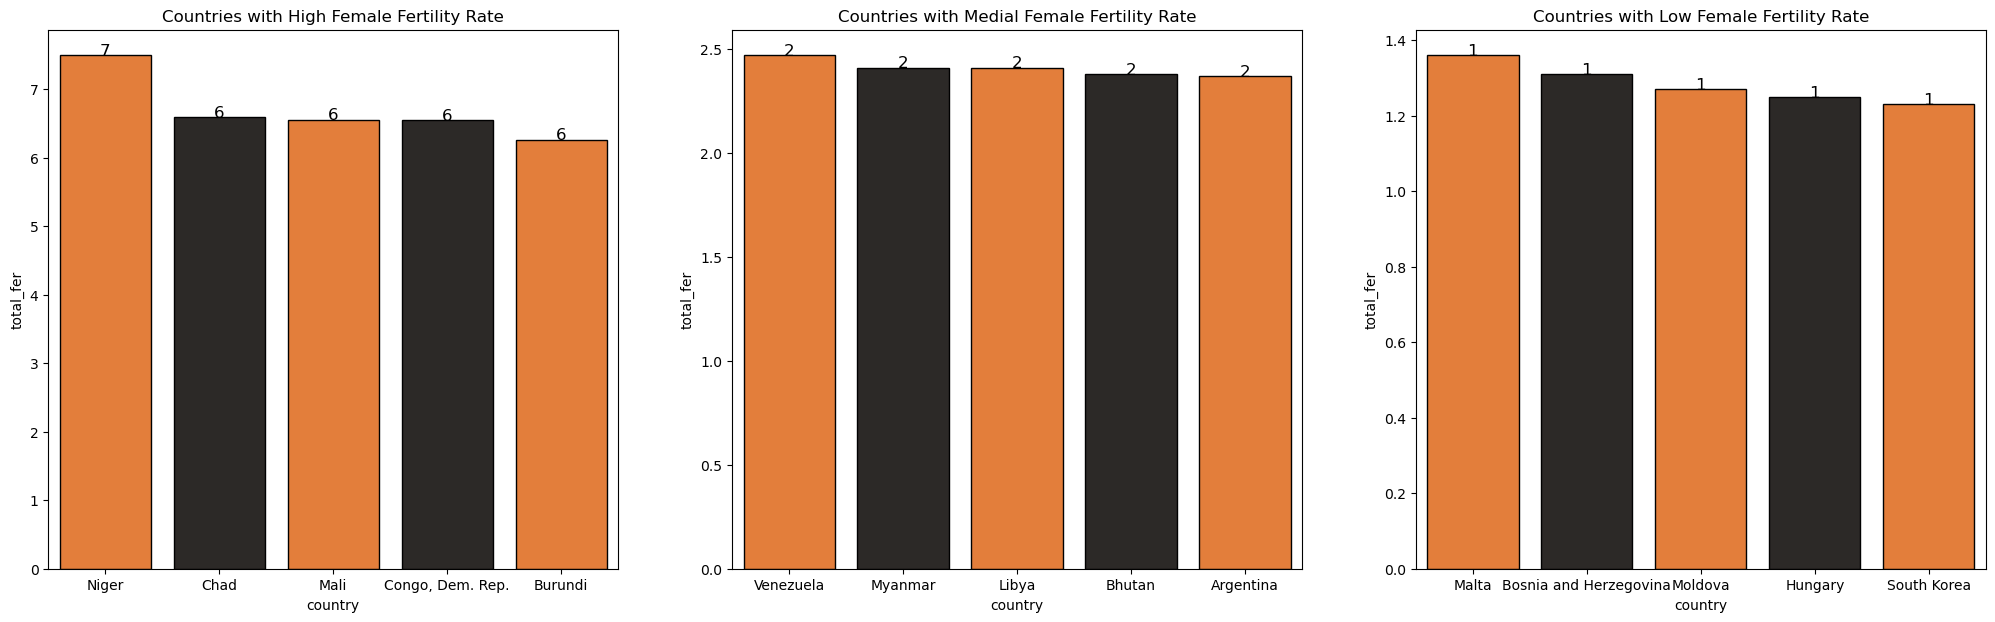

In [19]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,7))
plt.subplot(1,3,1)
ax = sns.barplot(x = 'country',y = 'total_fer', data = data.sort_values(ascending = False,by = 'total_fer').iloc[:5],palette = colors,edgecolor = 'black');
plt.title('Countries with High Female Fertility Rate')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,3,2)
ax = sns.barplot(x = 'country',y = 'total_fer', data = data.sort_values(ascending = False,by = 'total_fer').iloc[81:86],palette = colors,edgecolor = 'black');
plt.title('Countries with Medial Female Fertility Rate')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,3,3)
ax = sns.barplot(x = 'country',y = 'total_fer', data = data.sort_values(ascending = False,by = 'total_fer').iloc[161:166],palette = colors,edgecolor = 'black');
plt.title('Countries with Low Female Fertility Rate')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)
plt.show()

In [ ]:
'''
Африканские страны доминируют в total_fer со значениями 6+.
Среднее значение total_fer равно 2, тогда как нижние конечные значения, равные 1, также относятся к abit.

Gdpp: это функция, которая предоставляет информацию о вкладе гражданина в его ВВП.
'''

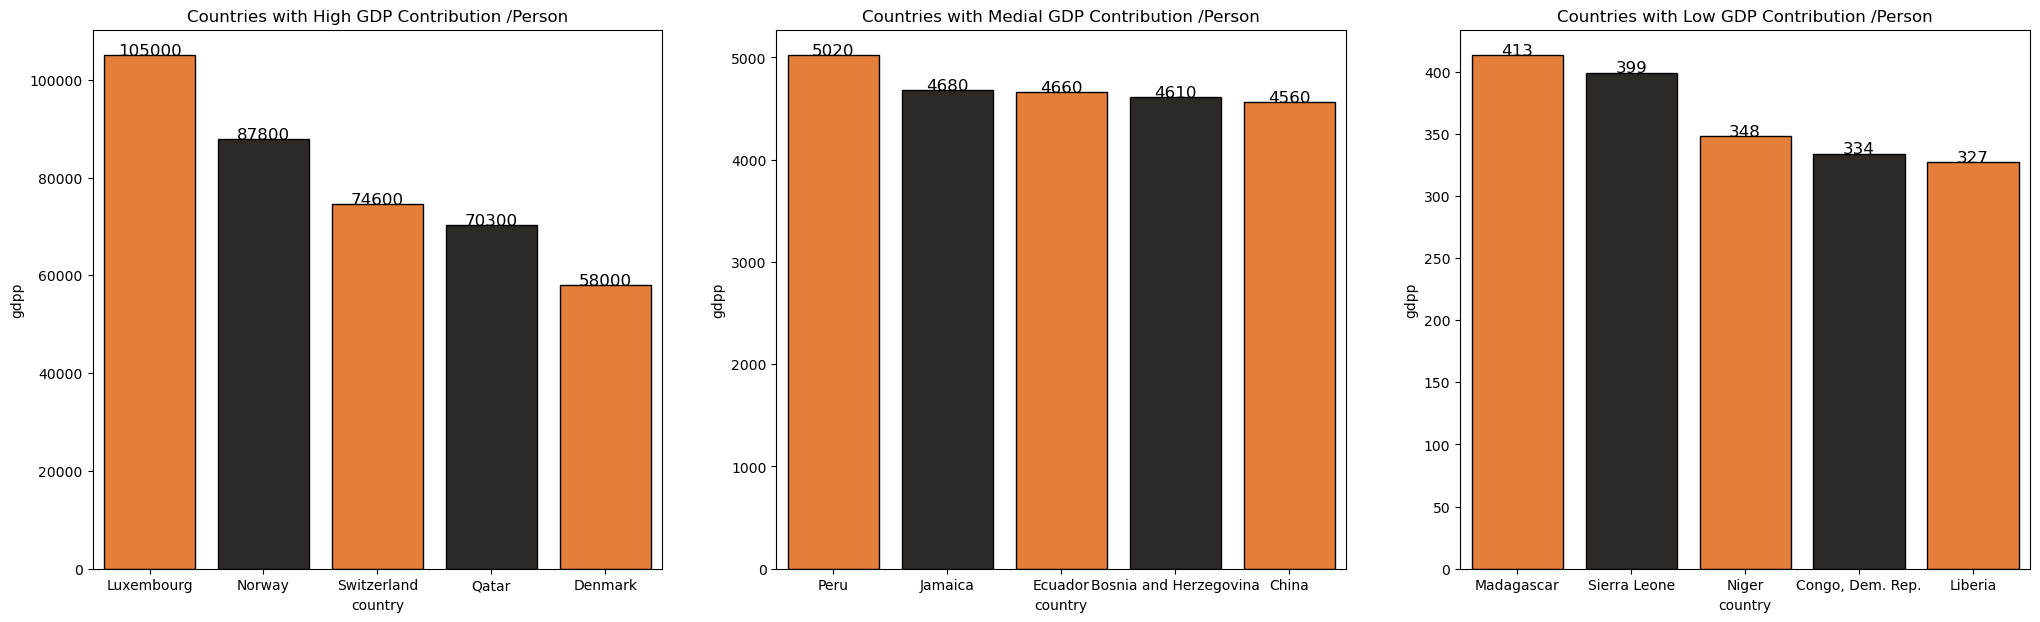

In [20]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,7))
plt.subplot(1,3,1)
ax = sns.barplot(x = 'country',y = 'gdpp', data = data.sort_values(ascending = False,by = 'gdpp').iloc[:5],palette = colors,edgecolor = 'black');
plt.title('Countries with High GDP Contribution /Person')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,3,2)
ax = sns.barplot(x = 'country',y = 'gdpp', data = data.sort_values(ascending = False,by = 'gdpp').iloc[81:86],palette = colors,edgecolor = 'black');
plt.title('Countries with Medial GDP Contribution /Person')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,3,3)
ax = sns.barplot(x = 'country',y = 'gdpp', data = data.sort_values(ascending = False,by = 'gdpp').iloc[161:166],palette = colors,edgecolor = 'black');
plt.title('Countries with Low GDP Contribution /Person')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)
plt.show()

In [ ]:
'''
Это сложный признак, поскольку население страны является важным фактором. 
Ярким примером этого является Китай. У него огромное население и огромный ВВП.
Люксембург снова присутствует в верхних строчках. Швейцария и Катар входят в пятерку лидеров по доходам.
В нижней части снова доминируют африканские страны, которые называют их экономически отсталыми.
'''

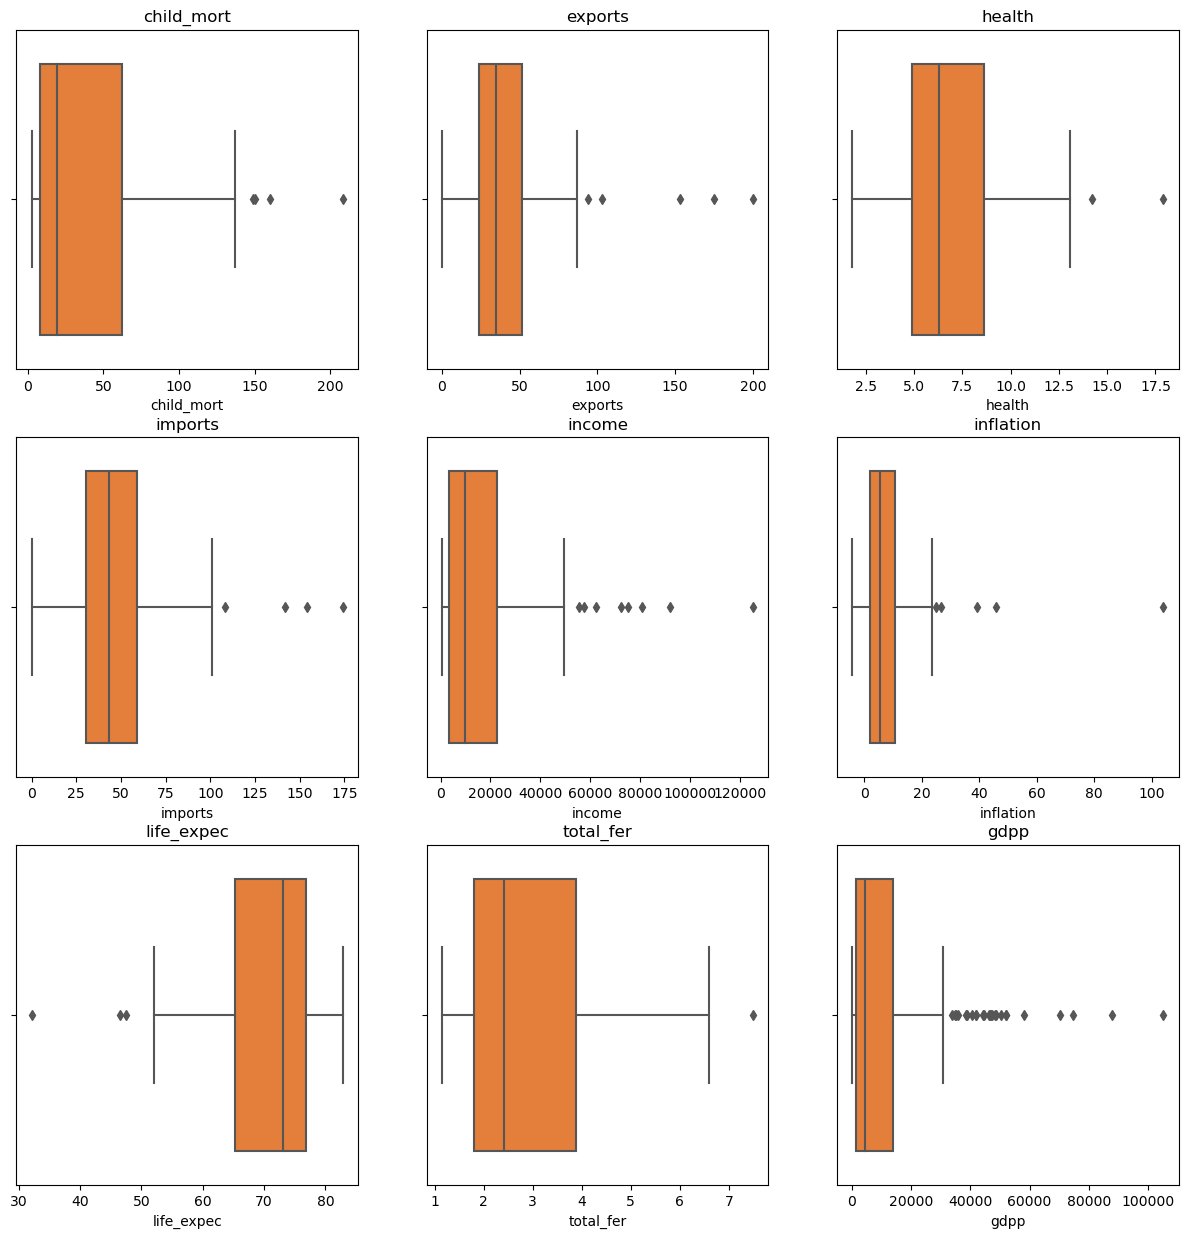

In [21]:
# Числовые признаки:

fig  = plt.subplots(nrows = 3,ncols = 3,figsize = (15,15))
for i in range(len(numerical_features)):
    plt.subplot(3,3,i+1)
    ax = sns.boxplot(data[numerical_features[i]],color = colors[0])
    plt.title(numerical_features[i])
plt.show()

In [ ]:
'''
ВЫВОДЫ EDA:
Из визуализаций и списка характеристик экономически отсталых стран можно получить множество идей.
Когда дело доходит до состояния здоровья, африканские страны занимают более высокие места во всех неправильных ситуациях. 
Они занимают значительную долю в странах с высоким уровнем child_mort, низким уровнем life_expec и высоким total_fer.
Все эти проблемы уже достаточно серьезны, и поэтому очень важно оказать им помощь в периоды непредвиденных потрясений. 
Несмотря на такие цифры, Гаити занимает первое место с высокими значениями child_mort. 
На другом конце находятся азиатские и европейские страны.
Граждане США тратят больше всего денег на свое здоровье, однако они не входят в топ-5 рейтингов life_expec и total_fer. 
Ни одна из стран с высоким показателем life_expec не входит в пятерку лучших стран по здравоохранению. 
Азиатские страны переполняют нижний уровень здравоохранения.
Сингапур, Мальта, Люксембург и Сейшельские острова входят в пятерку крупнейших стран экспорта, а также импорта. 
Численность населения и географическое положение играют решающую роль, когда речь идет об импорте и экспорте.
Судан — единственная африканская страна с низким импортом, а Бразилия имеет самый низкий импорт из всех.
Африканские страны демонстрируют очень высокие значения инфляции, тогда как страны всех континентов можно найти 
с низкими значениями инфляции.
Граждане Катара являются самыми высокооплачиваемыми, а Сингапур и Люксембург снова заняли места в пятерке стран 
с самым высоким доходом.
По ВВП Люксембург занимает лидирующие позиции. Швейцария и Катар входят в пятерку лидеров по доходам.
Африканские страны представлены в нижнем диапазоне доходов, а также ВВП. Колонизация нанесла огромный урон африканским странам.
'''

In [ ]:
'''
Feature Engineering
'''

In [22]:
data.head()

country  child_mort  exports  health  imports  income  \
0          Afghanistan       90.20    10.00    7.58    44.90    1610   
1              Albania       16.60    28.00    6.55    48.60    9930   
2              Algeria       27.30    38.40    4.17    31.40   12900   
3               Angola      119.00    62.30    2.85    42.90    5900   
4  Antigua and Barbuda       10.30    45.50    6.03    58.90   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44       56.20       5.82    553  
1       4.49       76.30       1.65   4090  
2      16.10       76.50       2.89   4460  
3      22.40       60.10       6.16   3530  
4       1.44       76.80       2.13  12200

In [23]:
data_new = data.drop('country', axis=1)


In [24]:
ut = np.triu(data_new.corr())
lt = np.tril(data_new.corr())


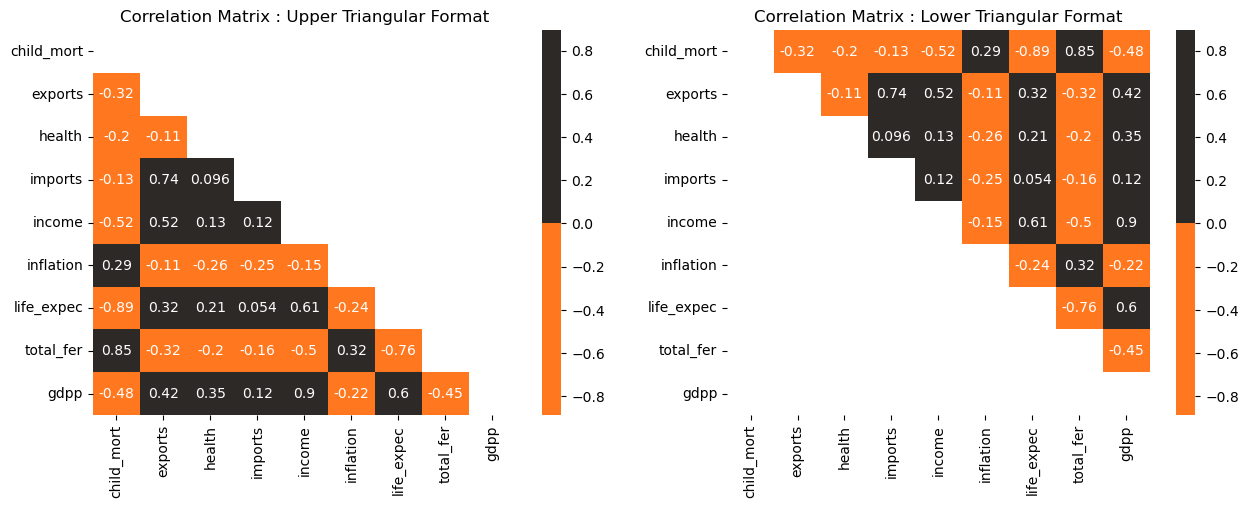

In [25]:
fig,ax = plt.subplots(nrows = 1, ncols = 2,figsize = (15,5))
plt.subplot(1,2,1)
sns.heatmap(data_new.corr(),cmap = colors,annot = True,cbar = 'True',mask = ut);
plt.title('Correlation Matrix : Upper Triangular Format');

plt.subplot(1,2,2)
sns.heatmap(data_new.corr(),cmap = colors,annot = True,cbar = 'True',mask = lt);
plt.title('Correlation Matrix : Lower Triangular Format');

In [ ]:
'''
Многие функции связаны друг с другом.
child_mort явно увеличивается, когда доходы, ВВП и экспорт уменьшаются. 
Рост инфляции также приводит к увеличению случаев детской смертности. 
Экономические условия, к сожалению, выступают важным фактором.
Рост экспорта явно увеличивает ВВП, доходы и импорт.
Расходы на здравоохранение немного увеличивают life_expec, а также уменьшают child_mort.
доход и ВВП имеют очень высокое значение корреляции 0,9. 
С точки зрения здравоохранения, высокий доход приводит к увеличению life_expec, но снижает total_fer на довольно значительную величину.
Как и ожидалось, высокая инфляция негативно влияет на финансовые показатели. 
Высокая инфляция отображает высокие значения total_fer и child_mort. Это характеризует типичные черты отсталой нации.
Согласно данным, более высокий life_expec отображает низкий total_fer. 
Более высокий ВВП привел к увеличению расходов на здравоохранение.

Мы ясно видим, что некоторые функции по существу относятся к одной и той же категории и имеют одинаковую реакцию 
на другие функции другой категории.

3 категории функций:
здоровье: child_mort, здоровье, life_expec, total_fer
торговля: импорт, экспорт
финансы: доходы, инфляция, ВВП
Следовательно, мы растворим эти функции в этих категориях и нормализуем их.
'''

In [ ]:
'''
Многие признаки связаны друг с другом.
child_mort явно увеличивается, когда доходы, ВВП и экспорт уменьшаются. 
Рост инфляции также приводит к увеличению случаев детской смертности. 
Экономические условия, к сожалению, выступают важным фактором!
Рост экспорта явно увеличивает ВВП, доходы и импорт.
Расходы на здравоохранение немного увеличивают life_expec, а также уменьшают child_mort.
доход и ВВП имеют очень высокое значение корреляции 0,9. 
С точки зрения здравоохранения, высокий доход приводит к увеличению life_expec, но снижает total_fer на довольно значительную 
величину.
Как и ожидалось, высокая инфляция негативно влияет на финансовые показатели. 
Высокая инфляция отображает высокие значения total_fer и child_mort. 
Это характеризует типичные черты отсталой нации.
Согласно данным, более высокий life_expec отображает низкий total_fer. 
Более высокий ВВП привел к увеличению расходов на здравоохранение.
Мы ясно видим, что некоторые функции по существу относятся к одной и той же категории и имеют одинаковую реакцию 
на другие функции другой категории.

3 категории функций:
торговля: импорт, экспорт
финансы: доходы, инфляция, ВВП
здоровье: child_mort, здоровье, life_expec, total_fer
торговля: импорт, экспорт
финансы: доходы, инфляция, ВВП
Следовательно, мы растворим эти функции в этих категориях и нормализуем их.
'''

In [26]:
df1 = pd.DataFrame()
df1['Health'] = (data['child_mort'] / data['child_mort'].mean()) + (data['health'] / data['health'].mean()) + (data['life_expec'] / data['life_expec'].mean()) + (data['total_fer'] / data['total_fer'].mean())
df1['Trade'] = (data['imports'] / data['imports'].mean()) + (data['exports'] / data['exports'].mean())
df1['Finance'] = (data['income'] / data['income'].mean()) + (data['inflation'] / data['inflation'].mean()) + (data['gdpp'] / data['gdpp'].mean())
df1.head()

Health  Trade  Finance
0    6.24   1.20     1.35
1    3.04   1.72     1.47
2    3.39   1.60     3.17
3    6.47   2.43     3.49
4    2.96   2.36     2.24

In [ ]:
'''
Масштабирование данных
'''

In [27]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Нормализация
ss = StandardScaler() # Стандартизация

df1['Health'] = mms.fit_transform(df1[['Health']])
df1['Trade'] = mms.fit_transform(df1[['Trade']])
df1['Finance'] = mms.fit_transform(df1[['Finance']])
df1.insert(loc = 0, value = list(data['country']), column = 'Country')
df1.head()

Country  Health  Trade  Finance
0          Afghanistan    0.63   0.14     0.08
1              Albania    0.13   0.20     0.09
2              Algeria    0.18   0.19     0.21
3               Angola    0.66   0.28     0.24
4  Antigua and Barbuda    0.12   0.28     0.15

In [ ]:
'''
Модель машинного обучения не понимает единицы измерения значений функций.
Он рассматривает входные данные как простое число, но не понимает истинного значения этого значения. 
Таким образом, возникает необходимость масштабирования данных.
Например: Возраст = Годы; FastingBS = mg/dl; Сборы = Валюта

У нас есть 2 варианта масштабирования данных:
1) Нормализация
2) Стандартизация.
Поскольку большинство алгоритмов предполагают, что данные имеют нормальное (гауссово) распределение, 
нормализация выполняется для объектов, данные которых не отображают нормальное распределение, 
а стандартизация выполняется для объектов, которые нормально распределены, 
где их значения огромны или очень малы по сравнению с другими особенностями.
Нормализация: функции здравоохранения, торговли и финансов нормализованы!
Стандартизация: Ни одна из функций не стандартизирована для приведенных выше данных.

Анализ главных компонентов (PCA):
Это метод уменьшения размерности, который предпочтительно используется для решения задач неконтролируемого обучения.
'''

In [28]:
df2 = data.copy(deep = True)

col = list(data.columns)
col.remove('health'); col.remove('country')

df2['health'] = ss.fit_transform(df2[['health']])

for i in col:
    df2[i] = mms.fit_transform(df2[[i]])
df2.drop(columns = 'country',inplace = True) 
df2.head()

child_mort  exports  health  imports  income  inflation  life_expec  \
0        0.43     0.05    0.28     0.26    0.01       0.13        0.48   
1        0.07     0.14   -0.10     0.28    0.07       0.08        0.87   
2        0.12     0.19   -0.97     0.18    0.10       0.19        0.88   
3        0.57     0.31   -1.45     0.25    0.04       0.25        0.55   
4        0.04     0.23   -0.29     0.34    0.15       0.05        0.88   

   total_fer  gdpp  
0       0.74  0.00  
1       0.08  0.04  
2       0.27  0.04  
3       0.79  0.03  
4       0.15  0.11

In [ ]:
'''
Прежде чем передавать данные для преобразования PCA, очень важны нормализация и стандартизация.
'''

In [29]:
from sklearn.decomposition import PCA

pca = PCA()
pca_df2 = pd.DataFrame(pca.fit_transform(df2))
pca.explained_variance_

array([1.01740511, 0.13090418, 0.03450018, 0.02679822, 0.00979752,
       0.00803398, 0.00307055, 0.00239976, 0.00179388])

In [ ]:
'''
Это значения дисперсии каждого объекта, присутствующего в наборе данных.
'''

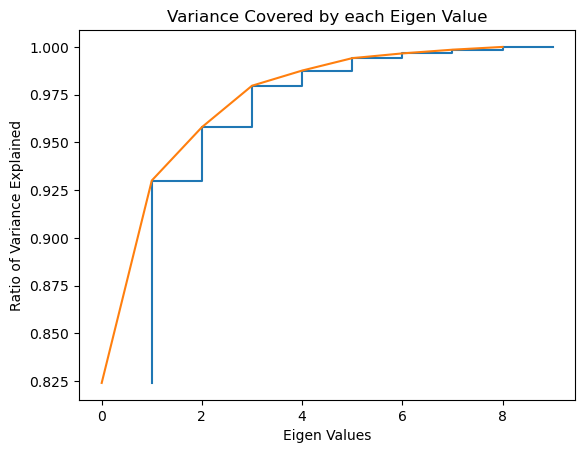

In [30]:
plt.step(list(range(1,10)), np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Eigen Values')
plt.ylabel('Ratio of Variance Explained')
plt.title('Variance Covered by each Eigen Value')
plt.show()

In [ ]:
'''
Это очень эффективный метод, при котором мы суммируем дисперсии всех функций в совокупном формате.
Обычно выбираются собственные значения с коэффициентом дисперсии более 95%.
Они соответствуют столбцам кадра данных, сгенерированного PCA.
В этом случае мы выбираем собственное значение: 2, поскольку сгенерированные шаги имеют значительные дисперсии, 
и, таким образом, их дисперсии доминируют над другими функциями.
'''

In [31]:
pca_df2 = pca_df2.drop(columns = [3,4,5,6,7,8])
pca_df2.head()

0     1     2
0  0.22  0.64  0.09
1 -0.08 -0.17 -0.21
2 -0.96 -0.13 -0.13
3 -1.51  0.47  0.28
4 -0.26 -0.24 -0.06

In [ ]:
'''
Теперь мы перейдем к разделу моделирования и сравним производительность двух наборов данных:
Комбинация функций: здравоохранение – торговля – финансы
Данные PCA
'''

In [ ]:
'''
Моделирование

Обучение без учителя: это проблема, когда целевая переменная / функция неизвестна. 
Проблемы неконтролируемого обучения широко встречаются в медицинской сфере, где проводятся многочисленные измерения, 
а основные заболевания неизвестны.
Таким образом, поиск закономерностей с использованием методов визуализации дает нам некоторое понимание, 
которое невозможно понять, глядя на табличные данные.
Однако, когда размер наборов данных становится огромным и слишком много признаков, 
визуализация данных может оказаться утомительной задачей. Следовательно, мы движемся к алгоритмическому подходу.
'''

In [32]:
m1 = df1.drop(columns = ['Country']).values # Комбинация признаков: Health - Trade - Finance
m2 = pca_df2.values # PCA Data

In [ ]:
'''
Кластеризация K-Means
Кластеризация K-Means — это алгоритм на основе расстояния, который используется для обучения без учителя 
и не поддерживает категориальные функции.

Это наиболее предпочтительный алгоритм для работы с обучением без учителя, который выполняет работу по поиску кластеров
в данных, но с использованием математического подхода:
Случайным образом выбирает 2 (предположим, k = 2) центроида.
Рассчитывается расстояние между центроидами и всеми точками данных.
Если точка данных находится ближе к одному из центроидов, она помечается как этот центроид и наоборот.
Для двух сформированных кластеров рассчитывается среднее значение точек данных, сгруппированных по любому из центроидов, 
и эти средние значения затем определяются как новые кластеры.
Этот процесс повторяется до тех пор, пока оба центроида не сойдутся в фиксированных точках.
Гиперпараметр k: определяет количество кластеров или групп, на которые следует разделить данные. 
Для выбора значений k мы используем 2 статистических теста:
Elbow Method: это метод, который отображает сумму квадратов ошибок для диапазона значений k. 
Если этот график выглядит как рука, то выбирается значение k, напоминающее локоть. 
Начиная с этого значения колена, сумма квадратов значений (инерция) начинает линейно уменьшаться 
и поэтому считается оптимальным значением.
Метод Silhouette Score: это метод, который оценивает качество кластеров с точки зрения того, 
насколько хорошо точки данных кластеризуются с другими точками данных, похожими друг на друга. 
Этот балл рассчитывается с использованием формулы расстояния, и для моделирования выбирается значение k с наивысшим баллом.
Комбинация признаков: здравоохранение – торговля – финансы
'''

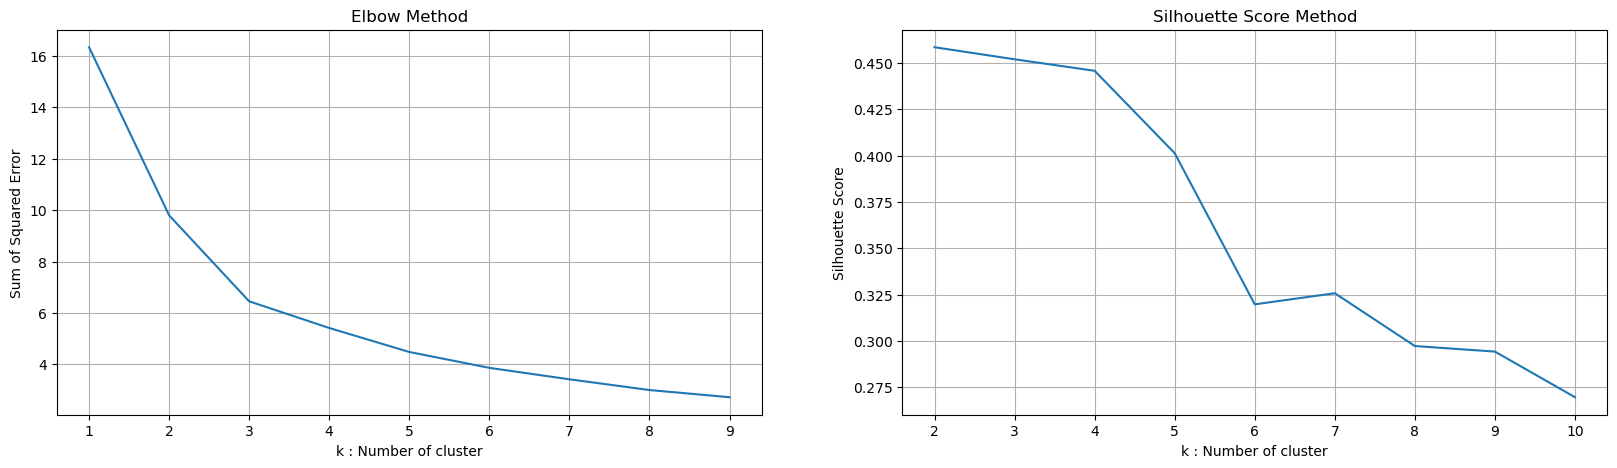

In [33]:
# Elbow Method & Silhouette Score Method:

sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(m1)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")
plt.grid()

plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(m1)
    labels = kmeans.labels_
    sil.append(silhouette_score(m1, labels, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.grid()

plt.show()

In [ ]:
'''
Из результатов двух вышеуказанных методов выбираем:
k = 3
'''

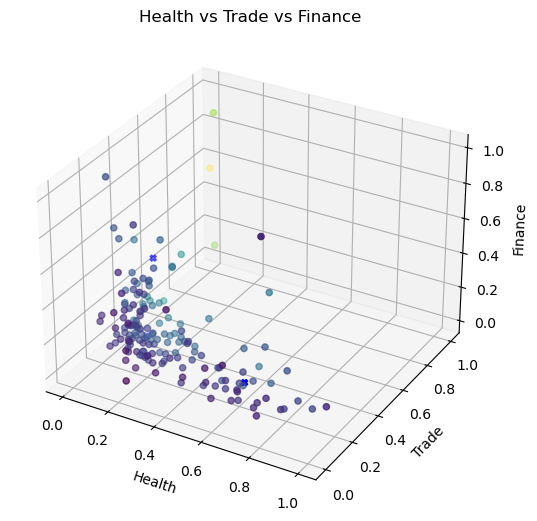

In [34]:
model = KMeans(n_clusters = 3,max_iter = 1000)
model.fit(m1)
cluster = model.cluster_centers_
centroids = np.array(cluster)
labels = model.labels_
data['Class'] = labels; df1['Class'] = labels

fig = plt.figure()
ax = Axes3D(fig)
x = np.array(df1['Health'])
y = np.array(df1['Trade'])
z = np.array(df1['Finance'])
ax.scatter(centroids[:,0],centroids[:,1],centroids[:,2],marker="X", color = 'b')
ax.scatter(x,y,z,c = y)
plt.title('Health vs Trade vs Finance')
ax.set_xlabel('Health')
ax.set_ylabel('Trade')
ax.set_zlabel('Finance')
plt.show();

In [ ]:
'''
Теперь у нас есть кластеры, но мы не знаем, какое значение чему соответствует.
Следовательно, мы рисуем коробчатую диаграмму дохода и child_mort с помеченными кластерами.
Мы знаем, что низкие доходы и высокая детская смертность – признак экономически отсталой страны.

'''

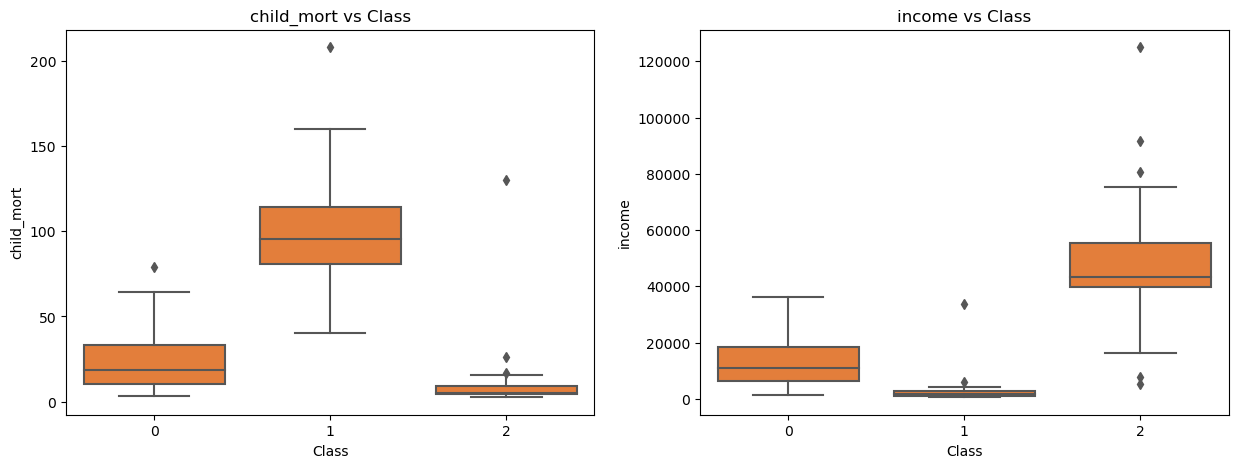

In [35]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'Class', y = 'child_mort', data  = data, color = '#FF781F');
plt.title('child_mort vs Class')

plt.subplot(1,2,2)
sns.boxplot(x = 'Class', y = 'income', data  = data, color = '#FF781F');
plt.title('income vs Class')

plt.show()

In [ ]:
'''
Из приведенного выше графика мы можем сделать вывод:
0: Возможно, понадобится помощь.
1: Помощь не требуется.
2: Нужна помощь.
'''

In [36]:
df1['Class'].loc[df1['Class'] == 0] = 'Might Need Help'
df1['Class'].loc[df1['Class'] == 1] = 'No Help Needed'
df1['Class'].loc[df1['Class'] == 2] = 'Help Needed'

fig = px.choropleth(df1[['Country','Class']],
                    locationmode = 'country names',
                    locations = 'Country',
                    title = 'Needed Help Per Country (World)',
                    color = df1['Class'],  
                    color_discrete_map = {'Help Needed':'Green',
                                        'No Help Needed':'Red',
                                        'Might Need Help':'Yellow'}
                   )
fig.update_geos(fitbounds = "locations", visible = True)
fig.update_layout(legend_title_text = 'Labels',legend_title_side = 'top',title_pad_l = 260,title_y = 0.86)
fig.show(engine = 'kaleido')

In [ ]:
'''
PCA Data
Elbow Method и Silhouette Score методы
'''

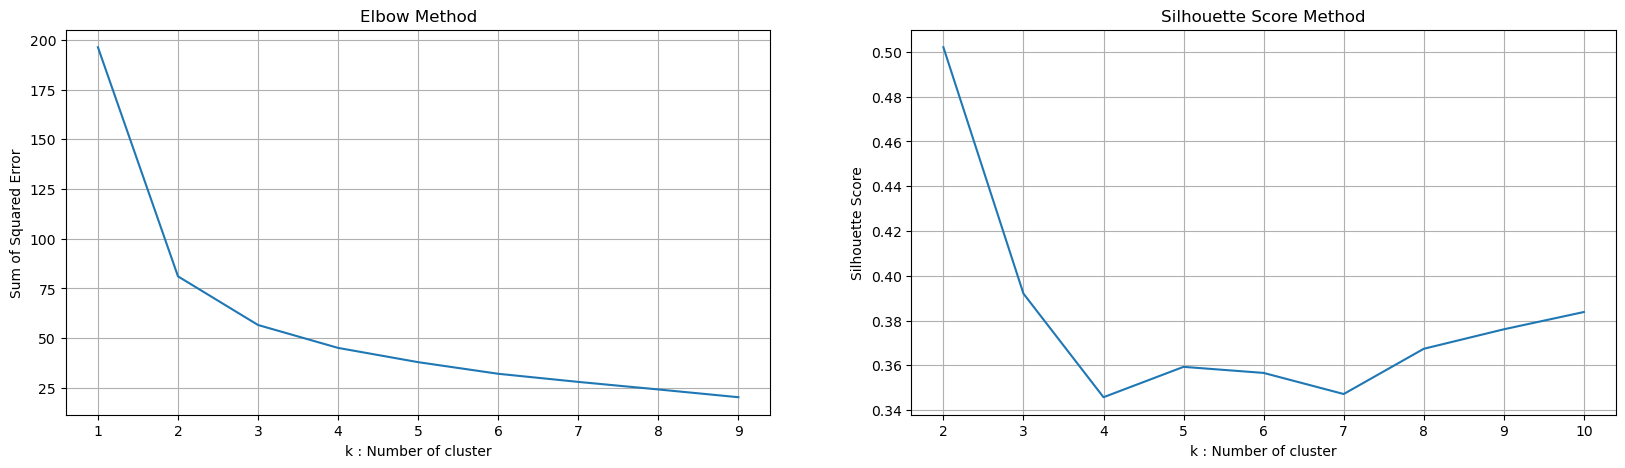

In [37]:
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow метод:
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(m2)
    sse[k] = kmeans.inertia_ # Инерция: сумма расстояний образцов до ближайшего цента кластера.
sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")
plt.grid()

# Silhouette Score метод
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(m2)
    labels = kmeans.labels_
    sil.append(silhouette_score(m2, labels, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.grid()

plt.show()

In [ ]:
'''
Из результатов двух вышеуказанных методов выбираем:
k = 3
'''

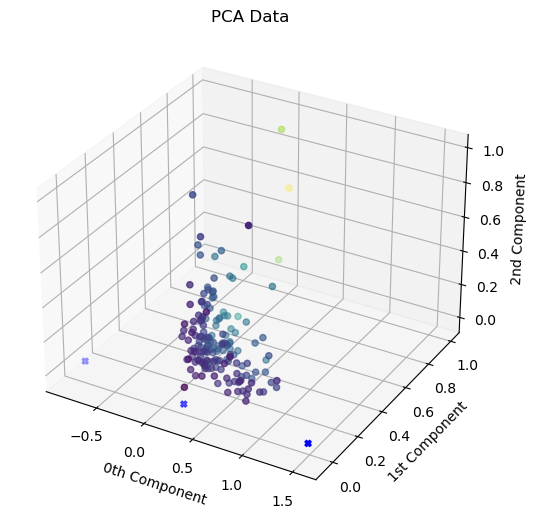

In [38]:
model = KMeans(n_clusters = 3,max_iter = 1000)
model.fit(m2)
cluster = model.cluster_centers_
centroids = np.array(cluster)
labels = model.labels_
data['Class'] = labels; pca_df2['Class'] = labels

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(centroids[:,0],centroids[:,1],centroids[:,2],marker="X", color = 'b')
plt.title('PCA Data')
ax.set_xlabel('0th Component')
ax.set_ylabel('1st Component')
ax.set_zlabel('2nd Component')
ax.scatter(x,y,z,c = y)
plt.show();

In [ ]:
'''
Мы снова проверяем диаграмму рассеяния доходов и child_mort относительно помеченных кластеров 
для подтверждения значений кластера.
Мы знаем, что низкие доходы и высокая детская смертность – признак экономически отсталой страны.
'''

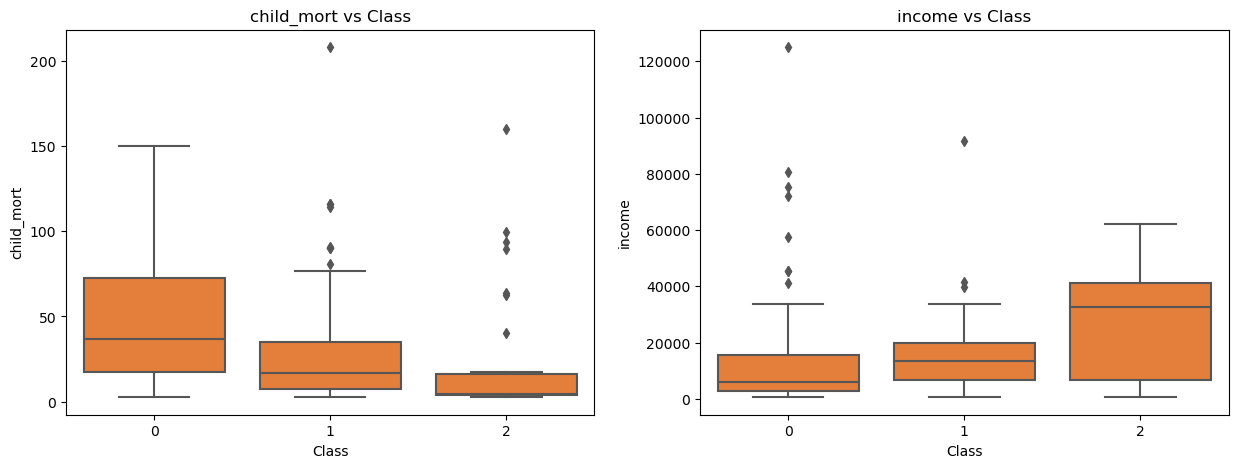

In [39]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'Class', y = 'child_mort', data  = data, color = '#FF781F');
plt.title('child_mort vs Class')

plt.subplot(1,2,2)
sns.boxplot(x = 'Class', y = 'income', data  = data, color = '#FF781F');
plt.title('income vs Class')

plt.show()

In [ ]:
'''
Из приведенного выше графика мы можем сделать вывод:
0: Возможно, понадобится помощь.
1: Нужна помощь.
2: Помощь не требуется.
'''

In [40]:
pca_df2.insert(0,column = 'Country', value = data['country'])

pca_df2['Class'].loc[pca_df2['Class'] == 0] = 'Might Need Help'
pca_df2['Class'].loc[pca_df2['Class'] == 1] = 'Help Needed'
pca_df2['Class'].loc[pca_df2['Class'] == 2] = 'No Help Needed'

fig = px.choropleth(pca_df2[['Country','Class']],
                    locationmode = 'country names',
                    locations = 'Country',
                    title = 'Needed Help Per Country (World)',
                    color = pca_df2['Class'],  
                    color_discrete_map = {'Help Needed':'Red',
                                          'Might Need Help':'Yellow',
                                          'No Help Needed': 'Green'})
fig.update_geos(fitbounds = "locations", visible = True)
fig.update_layout(legend_title_text = 'Labels',legend_title_side = 'top',title_pad_l = 260,title_y = 0.86)
fig.show(engine = 'kaleido')

In [ ]:
'''
Кластеризация DBSCAN — это алгоритм кластеризации на основе плотности, который используется для решения задач неконтролируемого 
обучения.

В попытке устранить проблемы кластеризации K-Means с вложенными и многомерными данными, кластеризация DBSCAN устраняет их. 
Он имеет 3 важных термина и 2 важных гиперпараметра:
Условия :
Основная точка: это центральная точка, в которой присутствует минимальное количество точек данных, 
а точки под ее областью могут расширять кластер.
Неосновная точка: это центральная точка, в которой нет минимального количества точек данных, и она не может расширять кластер.
Выбросы/шум: это точки данных, которые не являются частью какого-либо кластера.
Гиперпараметры:
minPts: это минимальное количество точек данных, которые должны присутствовать в области точки, 
чтобы ее можно было считать основной точкой.
Эпсилон: это радиус площади центральной точки.
DBSCAN Clustering создает кластеры следующим образом:
Выберите случайную точку и считайте ее центральной точкой данных.
Проверьте другие точки данных, которые присутствуют в области центральной точки, используя значение Эпсилон в качестве радиуса.
Если в этой области имеется количество точек данных minPts, то центральная точка считается базовой точкой.
Точки данных в этой области затем считаются базовой точкой, которая в дальнейшем расширяется по тем же правилам, образуя кластер.
Если какая-либо точка не удовлетворяет правилам, она считается неосновной точкой, которая остается частью кластера, 
но не может расширять кластер дальше.
Когда все основные точки завершены с охватом других точек данных, включаются неосновные точки, и кластер завершается.
Следующий кластер затем начинает формироваться по тем же правилам. Некоторые точки не входят ни в один из кластеров, 
такие точки известны как выбросы/шум.
Как вы могли заметить, гиперпараметры играют решающую роль в этом процессе. 
Таким образом, у них есть определенные правила присвоения им значений:
minPts: если D представляет количество измерений/объектов набора данных, то minPts >= D + 1. 
Обычно minPts >= 2 * D выбирается для меньших или зашумленных наборов данных.
Эпсилон: его значение обычно определяется с использованием графика k-расстояний, который определяется из модели KNN. 
Выбирается значение, при котором график резко меняется.
'''

In [41]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [ ]:
'''
Комбинация признаков : Health - Trade - Finance
'''

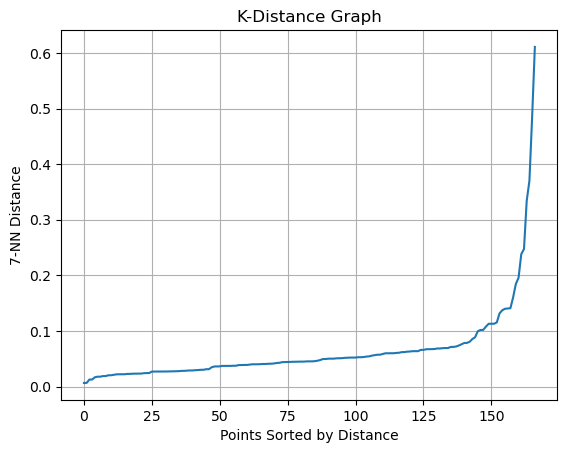

In [42]:
knn = NearestNeighbors(n_neighbors = 7)
model = knn.fit(m1)
distances, indices = knn.kneighbors(m1)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.grid()
plt.plot(distances);
plt.xlabel('Points Sorted by Distance')
plt.ylabel('7-NN Distance')
plt.title('K-Distance Graph');

In [43]:
'''
Выбираем minPts = 8 то есть >= 2 * 3 признака.
Значение, присвоенное n_neighbors:
minPts - 1.
На графике выше выбираем:
eps: 0.08
'''

'\nВыбираем minPts = 8 то есть >= 2 * 3 признака.\nЗначение, присвоенное n_neighbors:\nminPts - 1.\nНа графике выше выбираем:\neps: 0.08\n'

In [44]:
db = DBSCAN(eps = 0.080, min_samples = 8).fit(m1)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Количество кластеров в метках, игнорируя шум, если он есть.

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Number of Clusters : ', n_clusters_)
print('Number of Outliers : ', n_noise_)

data['Class'] = labels; df1['Class'] = labels

Number of Clusters :  3
Number of Outliers :  67


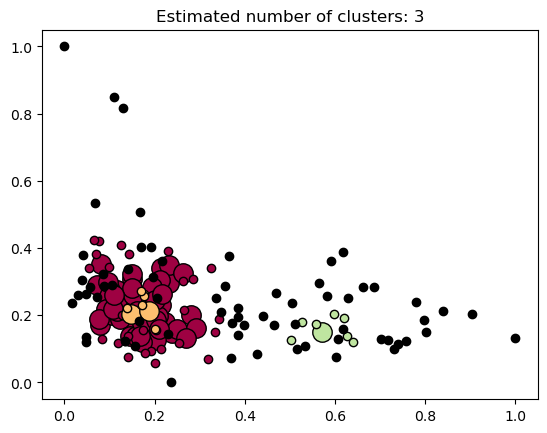

In [45]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Черный цвет для шума.
        col = [0, 0, 0, 1]
    class_member_mask = labels == k

    xy = m1[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor = tuple(col), markeredgecolor = "k", markersize = 14)

    xy = m1[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor = tuple(col), markeredgecolor = "k", markersize = 6)

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [ ]:
'''
Теперь у нас есть кластеры, но мы не знаем, какое значение чему соответствует.
Следовательно, мы рисуем коробчатые диаграммы дохода и child_mort с помеченными кластерами!
Мы знаем, что низкие доходы и высокая детская смертность – признак экономически отсталой страны.
'''

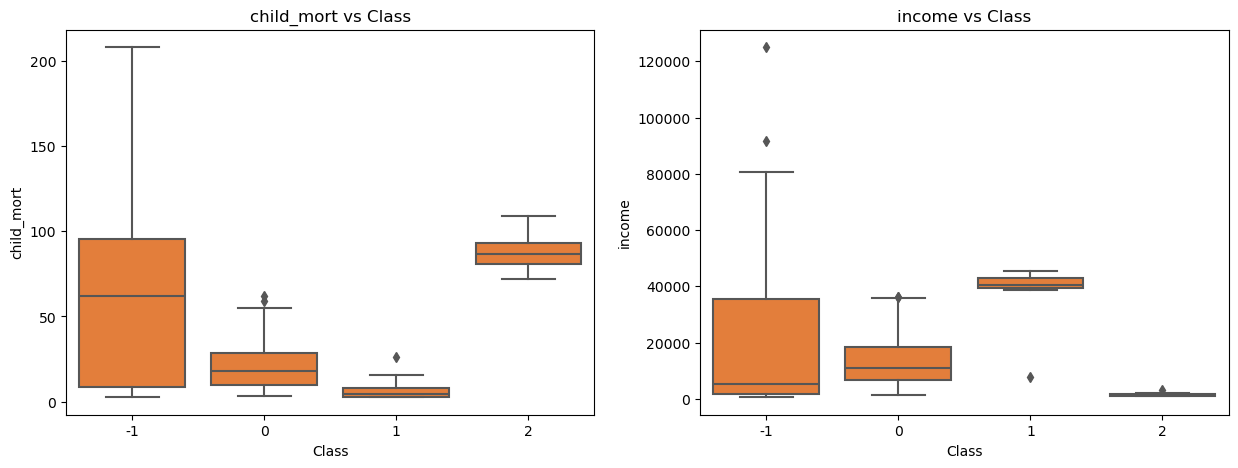

In [53]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'Class', y = 'child_mort', data  = data, color = '#FF781F');
plt.title('child_mort vs Class')

plt.subplot(1,2,2)
sns.boxplot(x = 'Class', y = 'income', data  = data, color = '#FF781F');
plt.title('income vs Class')

plt.show()

In [ ]:
'''
По правилу -1 связан с шумом/выбросами!
Из приведенного выше графика мы можем сделать вывод:
-1: Шум/Выбросы.
0: Возможно, понадобится помощь.
1: Помощь не требуется.
2: Нужна помощь.
'''

In [46]:
df1['Class'].loc[df1['Class'] == -1] = 'Noise / Outliers'
df1['Class'].loc[df1['Class'] == 0] = 'Might Need Help'
df1['Class'].loc[df1['Class'] == 1] = 'No Help Needed'
df1['Class'].loc[df1['Class'] == 2] = 'Help Needed'

fig = px.choropleth(df1[['Country','Class']],
                    locationmode = 'country names',
                    locations = 'Country',
                    title = 'Needed Help Per Country (World)',
                    color = df1['Class'],  
                    color_discrete_map={'Noise / Outliers' : 'Black',
                                        'Help Needed':'Red',
                                        'Might Need Help':'Yellow',
                                        'No Help Needed':'Green'})
fig.update_geos(fitbounds = "locations", visible = True)
fig.update_layout(legend_title_text = 'Labels',legend_title_side = 'top',title_pad_l = 260,title_y = 0.86)
fig.show(engine = 'kaleido')

In [ ]:
'''
PCA Data
'''

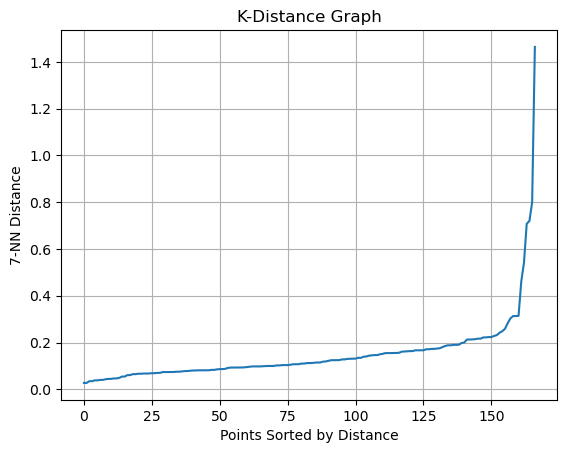

In [47]:
knn = NearestNeighbors(n_neighbors = 7)
model = knn.fit(m2)
distances, indices = knn.kneighbors(m2)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.xlabel('Points Sorted by Distance')
plt.ylabel('7-NN Distance')
plt.title('K-Distance Graph');
plt.grid()
plt.plot(distances);

In [ ]:
'''
Выбираем minPts = 8 то есть >= 2 * 3 признака.
Значение, присвоенное n_neighbors:
minPts - 1.
На графике выше выбираем:
eps: 0.08
'''

In [48]:
db = DBSCAN(eps = 0.2, min_samples = 8).fit(m2)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Number of Clusters : ', n_clusters_)
print('Number of Outliers : ', n_noise_)

data['Class'] = labels; pca_df2['Class'] = labels

Number of Clusters :  3
Number of Outliers :  94


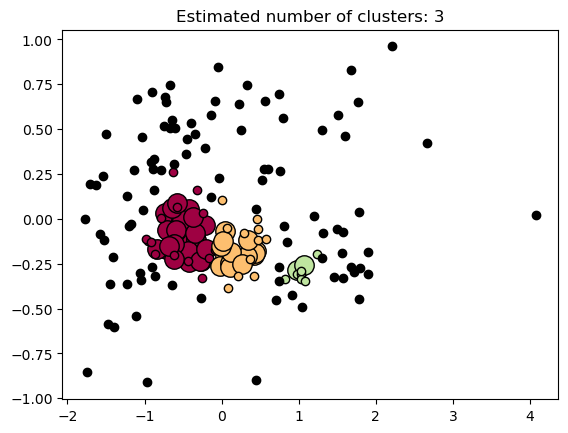

In [49]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    class_member_mask = labels == k

    xy = m2[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor = tuple(col), markeredgecolor = "k", markersize = 14)

    xy = m2[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor = tuple(col), markeredgecolor = "k", markersize = 6)

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

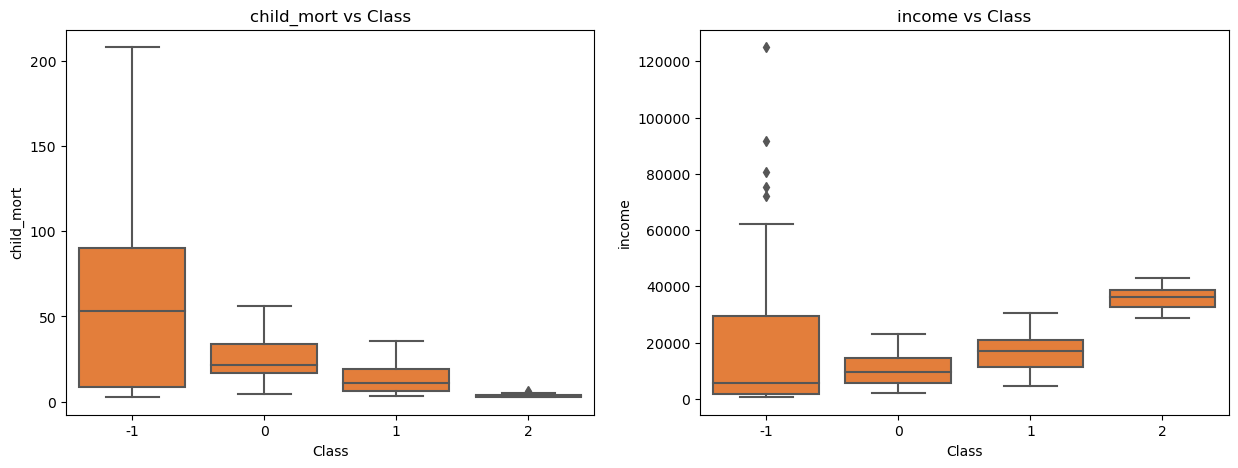

In [50]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'Class', y = 'child_mort', data  = data, color = '#FF781F');
plt.title('child_mort vs Class')

plt.subplot(1,2,2)
sns.boxplot(x = 'Class', y = 'income', data  = data, color = '#FF781F');
plt.title('income vs Class')

plt.show()

In [ ]:
'''
Из приведенного выше графика мы можем сделать вывод:
-1: Шум/Выбросы
0: Нужна помощь
1: Возможно, понадобится помощь
2: Помощь не требуется
'''

In [51]:
pca_df2['Class'].loc[pca_df2['Class'] == -1] = 'Noise / Outliers'
pca_df2['Class'].loc[pca_df2['Class'] == 0] = 'Help Needed'
pca_df2['Class'].loc[pca_df2['Class'] == 1] = 'Might Need Help'
pca_df2['Class'].loc[pca_df2['Class'] == 2] ='No Help Needed'

fig = px.choropleth(pca_df2[['Country','Class']],
                    locationmode = 'country names',
                    locations = 'Country',
                    title = 'Needed Help Per Country (World)',
                    color_discrete_sequence=["orange", "red", "green",'black'],
                    color = pca_df2['Class'],  
                    color_discrete_map={'Noise / Outliers' : 'Black',
                                        'Help Needed':'Red',
                                        'Might Need Help':'Yellow',
                                        'No Help Needed':'Green'})
fig.update_geos(fitbounds = "locations", visible = True)
fig.update_layout(legend_title_text = 'Labels',legend_title_side = 'top',title_pad_l = 260,title_y = 0.86)
fig.show(engine = 'kaleido')

In [ ]:
'''
Hierarchical Clustering.
Иерархическая кластеризация — это дистанционный алгоритм, который используется для решения задач обучения без учителя.

Он разрабатывает иерархию кластеров в форме дерева, известного как дендрограмма. 
Для этой проблемы мы собираемся использовать агломеративную кластеризацию, которая представляет собой восходящий подход, 
который рассматривает все точки как кластеры, а затем объединяет их вместе на основе их расстояний следующими способами:
Первоначально все точки рассматриваются как кластеры.
Затем кластеры, расположенные ближе друг к другу, начинают объединяться в новый кластер.
Затем этот объединенный кластер сравнивается с другими кластерами, и ближайший кластер объединяется.
Этот процесс продолжается до тех пор, пока не образуется один большой кластер.
Этот процесс формирования кластеров затем можно просмотреть с помощью дендрограммы. 
Из него мы выбираем количество кластеров, определив количество слияний, присутствующих на предпоследнем этапе. 
Чем больше длина вертикальных линий, тем выше расстояние между кластерами.
Чтобы выбрать количество кластеров, мы устанавливаем пороговое значение и подсчитываем количество вертикальных линий, 
присутствующих над ним. Это количество вертикальных линий образует количество кластеров. 
Также можно использовать другие методы, такие как метод оценки силуэта и метод локтя.
Для агломеративной кластеризации у нее есть 2 важных гиперпараметра:

linkage: существуют различные методы подключения или связывания для кластера, например, одиночный, центроидный, средний и т. д.

affinity: это формула расстояния, которая сравнивает расстояние перед объединением кластеров.
'''

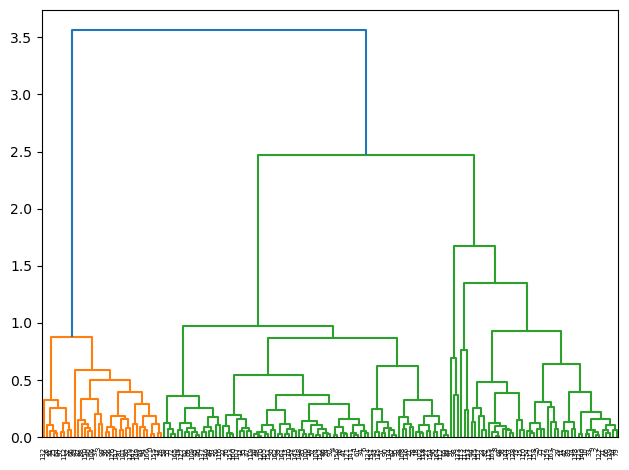

In [52]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_data = linkage(m1, method = 'ward', metric = 'euclidean')
dendrogram(linkage_data)
plt.tight_layout()
plt.show()

In [ ]:
'''
В данном случае нам необходимо разделить страны на 3 категории. 
Вот почему мы выберем сразу 3 кластера. 
Анализ дендрограммы для этого набора данных является излишним.
Здесь мы видим, что 1 синяя линия и 2 зеленые линии — это предпоследние кластеры, которые перед соединением вместе.
Он имеет 3 ветви, что указывает на 3 кластера, которые он создает перед слиянием в 1.
'''

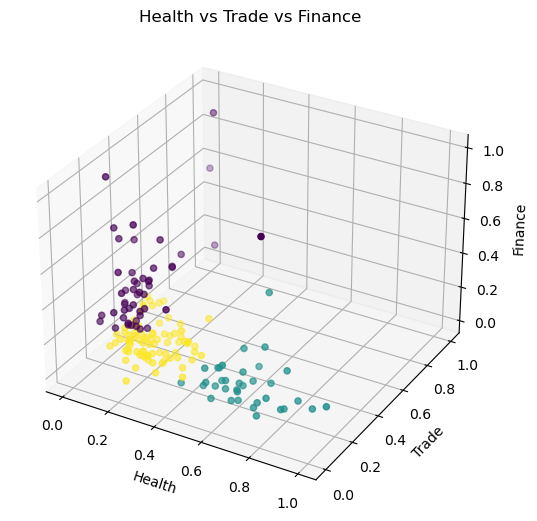

In [53]:
from sklearn.cluster import AgglomerativeClustering
hierarchical_cluster = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
labels = hierarchical_cluster.fit(m1)

pred_agc = pd.Series(hierarchical_cluster.labels_)
data['Class'] = pred_agc; df1['Class'] = pred_agc


fig = plt.figure()
ax = Axes3D(fig)
x = np.array(df1['Health'])
y = np.array(df1['Trade'])
z = np.array(df1['Finance'])
ax.scatter(x,y,z,c = df1['Class'])
plt.title('Health vs Trade vs Finance')
ax.set_xlabel('Health')
ax.set_ylabel('Trade')
ax.set_zlabel('Finance')
plt.show();

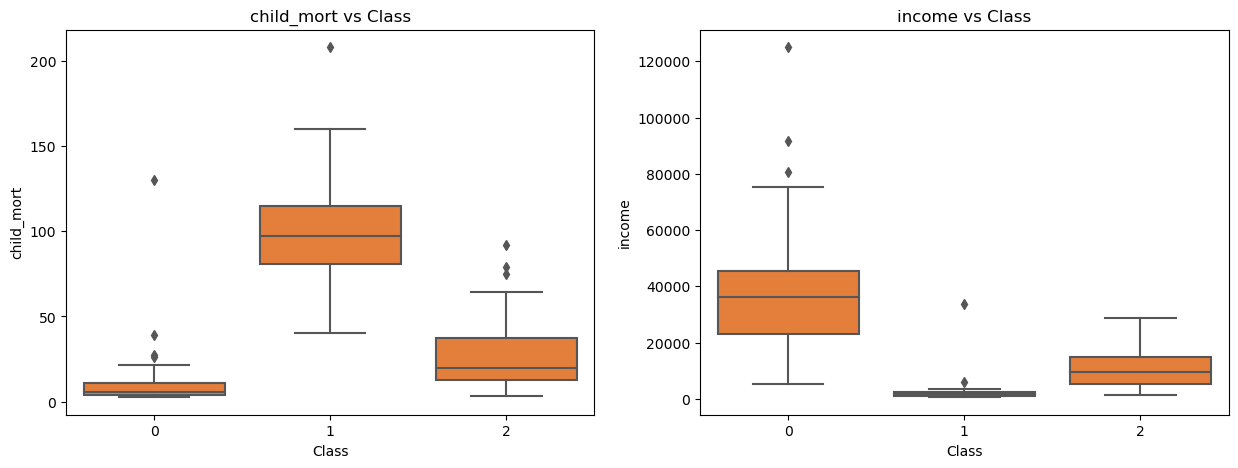

In [54]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'Class', y = 'child_mort', data  = data, color = '#FF781F');
plt.title('child_mort vs Class')

plt.subplot(1,2,2)
sns.boxplot(x = 'Class', y = 'income', data  = data, color = '#FF781F');
plt.title('income vs Class')

plt.show()

In [ ]:
'''
Из приведенного выше графика мы можем сделать вывод:
0: Помощь не требуется.
1: Нужна помощь.
2: Возможно, понадобится помощь.
'''

In [55]:
df1['Class'].loc[df1['Class'] == 0] = 'No Help Needed'
df1['Class'].loc[df1['Class'] == 1] = 'Help Needed'
df1['Class'].loc[df1['Class'] == 2] = 'Might Need Help'

fig = px.choropleth(df1[['Country','Class']],
                    locationmode = 'country names',
                    locations = 'Country',
                    title = 'Needed Help Per Country (World)',
                    color = df1['Class'],  
                    color_discrete_map = {'Help Needed' : 'Red',
                                          'Might Need Help' : 'Yellow',
                                          'No Help Needed' : 'Green'})
fig.update_geos(fitbounds = "locations", visible = True)
fig.update_layout(legend_title_text = 'Labels',legend_title_side = 'top',title_pad_l = 260,title_y = 0.86)
fig.show(engine = 'kaleido')

In [ ]:
'''
PCA Data
'''

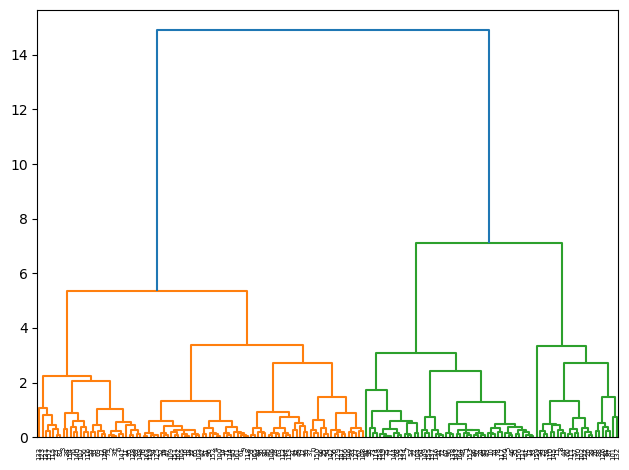

In [56]:
linkage_data = linkage(m2, method = 'ward', metric = 'euclidean')
dendrogram(linkage_data)
plt.tight_layout()
plt.show()

In [ ]:
'''
Аналогично предыдущему варианту построим три кластера.
'''

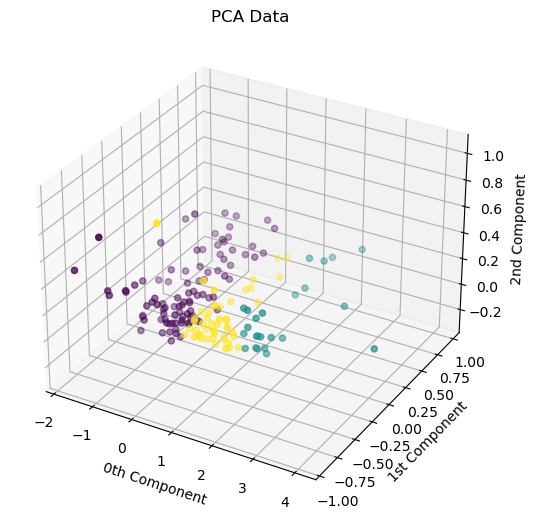

In [57]:
from sklearn.cluster import AgglomerativeClustering
hierarchical_cluster = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
labels = hierarchical_cluster.fit(m2)

pred_agc = pd.Series(hierarchical_cluster.labels_)
data['Class'] = pred_agc; pca_df2['Class'] = pred_agc


fig = plt.figure()
ax = Axes3D(fig)
x = np.array(pca_df2[0])
y = np.array(pca_df2[1])
z = np.array(pca_df2[2])
ax.scatter(x,y,z,c = pca_df2['Class'])
plt.title('PCA Data')
ax.set_xlabel('0th Component')
ax.set_ylabel('1st Component')
ax.set_zlabel('2nd Component')
plt.show();

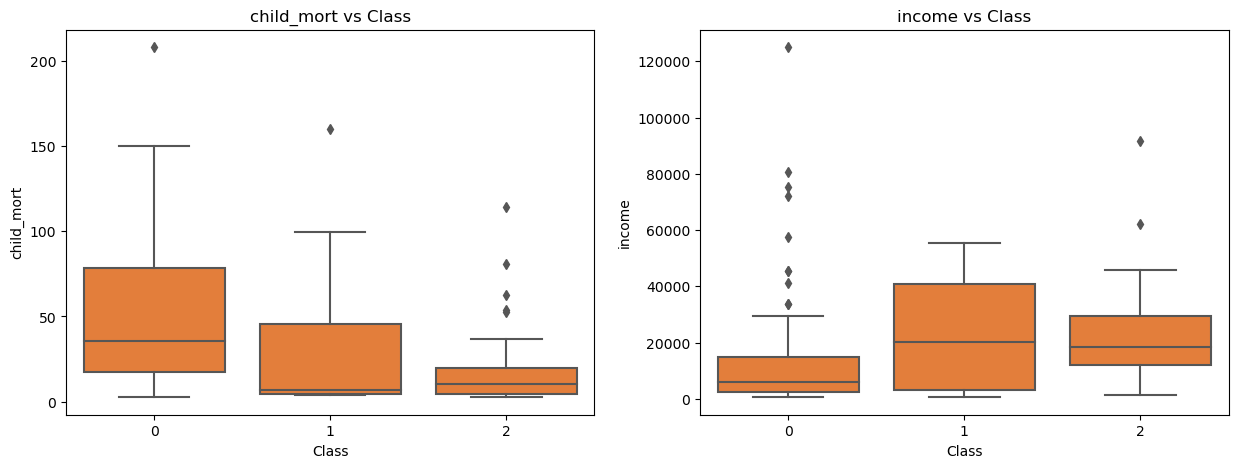

In [58]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'Class', y = 'child_mort', data  = data, color = '#FF781F');
plt.title('child_mort vs Class')

plt.subplot(1,2,2)
sns.boxplot(x = 'Class', y = 'income', data  = data, color = '#FF781F');
plt.title('income vs Class')

plt.show()

In [ ]:
'''
Из приведенного выше графика мы можем сделать вывод:
0: Нужна помощь.
1: Возможно, понадобится помощь.
2: Помощь не требуется.
'''

In [59]:
pca_df2['Class'].loc[pca_df2['Class'] == 0] = 'Help Needed'
pca_df2['Class'].loc[pca_df2['Class'] == 1] = 'Might Need Help'
pca_df2['Class'].loc[pca_df2['Class'] == 2] = 'No Help Needed'

fig = px.choropleth(pca_df2[['Country','Class']],
                    locationmode = 'country names',
                    locations = 'Country',
                    title = 'Needed Help Per Country (World)',
                    color = pca_df2['Class'],  
                    color_discrete_map={'Help Needed':'Red',
                                        'Might Need Help':'Yellow',
                                        'No Help Needed':'Green'})
fig.update_geos(fitbounds = "locations", visible = True)
fig.update_layout(legend_title_text = 'Labels',legend_title_side = 'top',title_pad_l = 260,title_y = 0.86)
fig.show(engine = 'kaleido')

In [ ]:
'''
Заключение
Это отличный набор данных, который был применен для благородного дела, которое подчеркивает масштабы использования практик науки о данных.
Производительность модели является отражением качества подаваемых в нее данных. 
В разделе EDA этого набора данных представлен список аналитических данных. 
Влияние нормализации и стандартизации огромно на производительность модели.
Разработка функций имеет решающее значение. Что касается комбинации признаков и данных PCA, четко видна сложность методов ее достижения. 
Эти процессы подчеркивают различные открытые варианты и, следовательно, требуют от нас разумного выбора методов в зависимости от данных и постановки задачи.
Кластеризация K-Means, Hierarchical кластеризация и кластеризация DBSCAN принципиально отличаются. 
Они основаны на разных принципах, что отражает разницу в характеристиках моделей. В целом характеристики модели не так хороши.
'''